# Medical Image Classification

In [1]:
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
import os
import PIL
import time
import psutil
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 10.2.0
Tensorboard version: 2.19.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.49.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

In [2]:
seed = 4
np.random.seed(seed)

## Continue working with OrganMNIST3d 64x64x64

In [3]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [4]:
root_dir = '/mnt/hdd/marina/.medmnist/'
reports_dir = 'reports/'

In [5]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [6]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [7]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        volume, label = self.dataset[idx]
        volume = torch.tensor(volume, dtype=torch.float32)

        axial, coronal, sagittal = self.extract_2d_slices(volume)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(volume):
        axial = volume.permute(1, 0, 2, 3).flatten(0, 1)
        coronal = volume.permute(2, 0, 1, 3).flatten(0, 1)
        sagittal = volume.permute(3, 0, 1, 2).flatten(0, 1)

        return axial, sagittal, coronal


In [8]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

# Axial part

## Pretrained

In [9]:
auc_metric = ROCAUCMetric()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
print(model)

ResNet(
  (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [12]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70
epoch 1 average loss: 1.9634


Epochs:   1%|▏         | 1/70 [00:18<21:41, 18.86s/it]

1
saved new best metric model
current epoch: 1 current AUC: 0.9317 current accuracy: 0.6584 best AUC: 0.9317 at epoch: 1
----------
epoch 2/70
epoch 2 average loss: 1.1446


Epochs:   3%|▎         | 2/70 [00:36<20:20, 17.94s/it]

1
saved new best metric model
current epoch: 2 current AUC: 0.9836 current accuracy: 0.7578 best AUC: 0.9836 at epoch: 2
----------
epoch 3/70
epoch 3 average loss: 0.8949


Epochs:   4%|▍         | 3/70 [00:53<19:44, 17.68s/it]

1
saved new best metric model
current epoch: 3 current AUC: 0.9920 current accuracy: 0.8323 best AUC: 0.9920 at epoch: 3
----------
epoch 4/70
epoch 4 average loss: 0.7084


Epochs:   6%|▌         | 4/70 [01:11<19:22, 17.61s/it]

1
saved new best metric model
current epoch: 4 current AUC: 0.9953 current accuracy: 0.9193 best AUC: 0.9953 at epoch: 4
----------
epoch 5/70
epoch 5 average loss: 0.6325


Epochs:   7%|▋         | 5/70 [01:28<19:01, 17.56s/it]

1
saved new best metric model
current epoch: 5 current AUC: 0.9989 current accuracy: 0.9193 best AUC: 0.9989 at epoch: 5
----------
epoch 6/70
epoch 6 average loss: 0.5580


Epochs:   9%|▊         | 6/70 [01:45<18:38, 17.47s/it]

1
current epoch: 6 current AUC: 0.9977 current accuracy: 0.9503 best AUC: 0.9989 at epoch: 5
----------
epoch 7/70
epoch 7 average loss: 0.4619


Epochs:  10%|█         | 7/70 [02:03<18:15, 17.39s/it]

1
saved new best metric model
current epoch: 7 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 0.9998 at epoch: 7
----------
epoch 8/70
epoch 8 average loss: 0.4422


Epochs:  11%|█▏        | 8/70 [02:20<17:57, 17.39s/it]

1
saved new best metric model
current epoch: 8 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 9/70
epoch 9 average loss: 0.3907


Epochs:  13%|█▎        | 9/70 [02:37<17:34, 17.29s/it]

1
current epoch: 9 current AUC: 0.9994 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 8
----------
epoch 10/70
epoch 10 average loss: 0.3386


Epochs:  14%|█▍        | 10/70 [02:54<17:15, 17.25s/it]

1
current epoch: 10 current AUC: 0.9999 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 8
----------
epoch 11/70
epoch 11 average loss: 0.3386


Epochs:  16%|█▌        | 11/70 [03:11<16:56, 17.24s/it]

1
current epoch: 11 current AUC: 0.9996 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 8
----------
epoch 12/70
epoch 12 average loss: 0.3084


Epochs:  17%|█▋        | 12/70 [03:28<16:35, 17.16s/it]

1
current epoch: 12 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 8
----------
epoch 13/70
epoch 13 average loss: 0.2814


Epochs:  19%|█▊        | 13/70 [03:46<16:18, 17.17s/it]

1
current epoch: 13 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 14/70
epoch 14 average loss: 0.2561


Epochs:  20%|██        | 14/70 [04:03<16:02, 17.18s/it]

1
current epoch: 14 current AUC: 0.9999 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 8
----------
epoch 15/70
epoch 15 average loss: 0.2381


Epochs:  21%|██▏       | 15/70 [04:20<15:46, 17.20s/it]

1
current epoch: 15 current AUC: 0.9996 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 16/70
epoch 16 average loss: 0.1920


Epochs:  23%|██▎       | 16/70 [04:37<15:28, 17.19s/it]

1
current epoch: 16 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 17/70
epoch 17 average loss: 0.1604


Epochs:  24%|██▍       | 17/70 [04:54<15:12, 17.21s/it]

1
current epoch: 17 current AUC: 0.9990 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 8
----------
epoch 18/70
epoch 18 average loss: 0.1502


Epochs:  26%|██▌       | 18/70 [05:12<14:55, 17.22s/it]

1
current epoch: 18 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 19/70
epoch 19 average loss: 0.1430


Epochs:  27%|██▋       | 19/70 [05:29<14:41, 17.28s/it]

1
current epoch: 19 current AUC: 0.9996 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 20/70
epoch 20 average loss: 0.1720


Epochs:  29%|██▊       | 20/70 [05:46<14:25, 17.32s/it]

1
current epoch: 20 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 21/70
epoch 21 average loss: 0.1385


Epochs:  30%|███       | 21/70 [06:04<14:09, 17.34s/it]

1
current epoch: 21 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 22/70
epoch 22 average loss: 0.1688


Epochs:  31%|███▏      | 22/70 [06:21<13:55, 17.40s/it]

1
current epoch: 22 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 23/70
epoch 23 average loss: 0.1377


Epochs:  33%|███▎      | 23/70 [06:39<13:41, 17.48s/it]

1
current epoch: 23 current AUC: 0.9994 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 24/70
epoch 24 average loss: 0.1412


Epochs:  34%|███▍      | 24/70 [06:57<13:24, 17.49s/it]

1
current epoch: 24 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 25/70
epoch 25 average loss: 0.1504


Epochs:  36%|███▌      | 25/70 [07:14<13:08, 17.52s/it]

1
current epoch: 25 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 26/70
epoch 26 average loss: 0.1148


Epochs:  37%|███▋      | 26/70 [07:32<12:52, 17.56s/it]

1
current epoch: 26 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 27/70
epoch 27 average loss: 0.1126


Epochs:  39%|███▊      | 27/70 [07:49<12:34, 17.54s/it]

1
current epoch: 27 current AUC: 0.9996 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 28/70
epoch 28 average loss: 0.0891


Epochs:  40%|████      | 28/70 [08:07<12:15, 17.52s/it]

1
current epoch: 28 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 29/70
epoch 29 average loss: 0.0986


Epochs:  41%|████▏     | 29/70 [08:24<11:59, 17.54s/it]

1
current epoch: 29 current AUC: 0.9990 current accuracy: 0.9379 best AUC: 1.0000 at epoch: 8
----------
epoch 30/70
epoch 30 average loss: 0.1114


Epochs:  43%|████▎     | 30/70 [08:42<11:42, 17.56s/it]

1
current epoch: 30 current AUC: 0.9997 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 8
----------
epoch 31/70
epoch 31 average loss: 0.0887


Epochs:  44%|████▍     | 31/70 [08:59<11:21, 17.47s/it]

1
current epoch: 31 current AUC: 0.9992 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 8
----------
epoch 32/70
epoch 32 average loss: 0.0544


Epochs:  46%|████▌     | 32/70 [09:17<11:03, 17.46s/it]

1
current epoch: 32 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 33/70
epoch 33 average loss: 0.0998


Epochs:  47%|████▋     | 33/70 [09:34<10:46, 17.47s/it]

1
current epoch: 33 current AUC: 0.9993 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 34/70
epoch 34 average loss: 0.1137


Epochs:  49%|████▊     | 34/70 [09:52<10:29, 17.50s/it]

1
current epoch: 34 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 8
----------
epoch 35/70
epoch 35 average loss: 0.0598


Epochs:  50%|█████     | 35/70 [10:09<10:09, 17.42s/it]

1
current epoch: 35 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 36/70
epoch 36 average loss: 0.0690


Epochs:  51%|█████▏    | 36/70 [10:27<09:54, 17.47s/it]

1
current epoch: 36 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 37/70
epoch 37 average loss: 0.0602


Epochs:  53%|█████▎    | 37/70 [10:44<09:38, 17.52s/it]

1
current epoch: 37 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 8
----------
epoch 38/70
epoch 38 average loss: 0.0787


Epochs:  54%|█████▍    | 38/70 [11:02<09:19, 17.48s/it]

1
current epoch: 38 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 39/70
epoch 39 average loss: 0.0647


Epochs:  56%|█████▌    | 39/70 [11:19<09:02, 17.51s/it]

1
current epoch: 39 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 40/70
epoch 40 average loss: 0.0941


Epochs:  57%|█████▋    | 40/70 [11:37<08:44, 17.47s/it]

1
current epoch: 40 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 41/70
epoch 41 average loss: 0.0947


Epochs:  59%|█████▊    | 41/70 [11:54<08:27, 17.51s/it]

1
current epoch: 41 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 42/70
epoch 42 average loss: 0.0699


Epochs:  60%|██████    | 42/70 [12:12<08:09, 17.49s/it]

1
current epoch: 42 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 43/70
epoch 43 average loss: 0.0427


Epochs:  61%|██████▏   | 43/70 [12:29<07:50, 17.43s/it]

1
current epoch: 43 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 44/70
epoch 44 average loss: 0.0565


Epochs:  63%|██████▎   | 44/70 [12:46<07:34, 17.47s/it]

1
current epoch: 44 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 45/70
epoch 45 average loss: 0.0774


Epochs:  64%|██████▍   | 45/70 [13:04<07:17, 17.52s/it]

1
current epoch: 45 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 46/70
epoch 46 average loss: 0.0581


Epochs:  66%|██████▌   | 46/70 [13:22<07:01, 17.55s/it]

1
current epoch: 46 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 47/70
epoch 47 average loss: 0.0690


Epochs:  67%|██████▋   | 47/70 [13:39<06:43, 17.53s/it]

1
current epoch: 47 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 48/70
epoch 48 average loss: 0.0726


Epochs:  69%|██████▊   | 48/70 [13:57<06:25, 17.54s/it]

1
current epoch: 48 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 49/70
epoch 49 average loss: 0.0891


Epochs:  70%|███████   | 49/70 [14:14<06:08, 17.55s/it]

1
current epoch: 49 current AUC: 0.9987 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 50/70
epoch 50 average loss: 0.0864


Epochs:  71%|███████▏  | 50/70 [14:32<05:50, 17.52s/it]

1
current epoch: 50 current AUC: 0.9997 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 51/70
epoch 51 average loss: 0.0564


Epochs:  73%|███████▎  | 51/70 [14:49<05:33, 17.56s/it]

1
current epoch: 51 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 52/70
epoch 52 average loss: 0.1159


Epochs:  74%|███████▍  | 52/70 [15:07<05:15, 17.53s/it]

1
current epoch: 52 current AUC: 0.9997 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 53/70
epoch 53 average loss: 0.0427


Epochs:  76%|███████▌  | 53/70 [15:25<04:59, 17.60s/it]

1
current epoch: 53 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 54/70
epoch 54 average loss: 0.0467


Epochs:  77%|███████▋  | 54/70 [15:42<04:40, 17.55s/it]

1
current epoch: 54 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 55/70
epoch 55 average loss: 0.0479


Epochs:  79%|███████▊  | 55/70 [16:00<04:22, 17.53s/it]

1
current epoch: 55 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 56/70
epoch 56 average loss: 0.0713


Epochs:  80%|████████  | 56/70 [16:17<04:04, 17.48s/it]

1
current epoch: 56 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 57/70
epoch 57 average loss: 0.0440


Epochs:  81%|████████▏ | 57/70 [16:35<03:47, 17.53s/it]

1
current epoch: 57 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 58/70
epoch 58 average loss: 0.0514


Epochs:  83%|████████▎ | 58/70 [16:52<03:30, 17.57s/it]

1
current epoch: 58 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 59/70
epoch 59 average loss: 0.0270


Epochs:  84%|████████▍ | 59/70 [17:10<03:12, 17.51s/it]

1
current epoch: 59 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 60/70
epoch 60 average loss: 0.0714


Epochs:  86%|████████▌ | 60/70 [17:27<02:55, 17.52s/it]

1
current epoch: 60 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 61/70
epoch 61 average loss: 0.0410


Epochs:  87%|████████▋ | 61/70 [17:45<02:38, 17.57s/it]

1
current epoch: 61 current AUC: 0.9995 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 62/70
epoch 62 average loss: 0.0586


Epochs:  89%|████████▊ | 62/70 [18:02<02:19, 17.48s/it]

1
current epoch: 62 current AUC: 0.9996 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 8
----------
epoch 63/70
epoch 63 average loss: 0.0329


Epochs:  90%|█████████ | 63/70 [18:20<02:02, 17.52s/it]

1
current epoch: 63 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 64/70
epoch 64 average loss: 0.0336


Epochs:  91%|█████████▏| 64/70 [18:37<01:45, 17.53s/it]

1
current epoch: 64 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 8
----------
epoch 65/70
epoch 65 average loss: 0.0360


Epochs:  93%|█████████▎| 65/70 [18:55<01:27, 17.54s/it]

1
current epoch: 65 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 66/70
epoch 66 average loss: 0.0561


Epochs:  94%|█████████▍| 66/70 [19:12<01:10, 17.56s/it]

1
current epoch: 66 current AUC: 1.0000 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
----------
epoch 67/70
epoch 67 average loss: 0.0517


Epochs:  96%|█████████▌| 67/70 [19:30<00:52, 17.53s/it]

1
current epoch: 67 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 8
----------
epoch 68/70
epoch 68 average loss: 0.0275


Epochs:  97%|█████████▋| 68/70 [19:47<00:35, 17.53s/it]

1
current epoch: 68 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 8
----------
epoch 69/70
epoch 69 average loss: 0.0394


Epochs:  99%|█████████▊| 69/70 [20:05<00:17, 17.47s/it]

1
current epoch: 69 current AUC: 0.9991 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 8
----------
epoch 70/70
epoch 70 average loss: 0.0684


Epochs: 100%|██████████| 70/70 [20:22<00:00, 17.47s/it]

1
current epoch: 70 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 8
train completed, best_metric: 1.0000 at epoch: 8


In [13]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1222.69 seconds
CPU time used: 14643.00 seconds
Memory used: 3550.26 MB
GPU Memory Used: 192.62 MB
Max GPU Memory Used: 237.87 MB


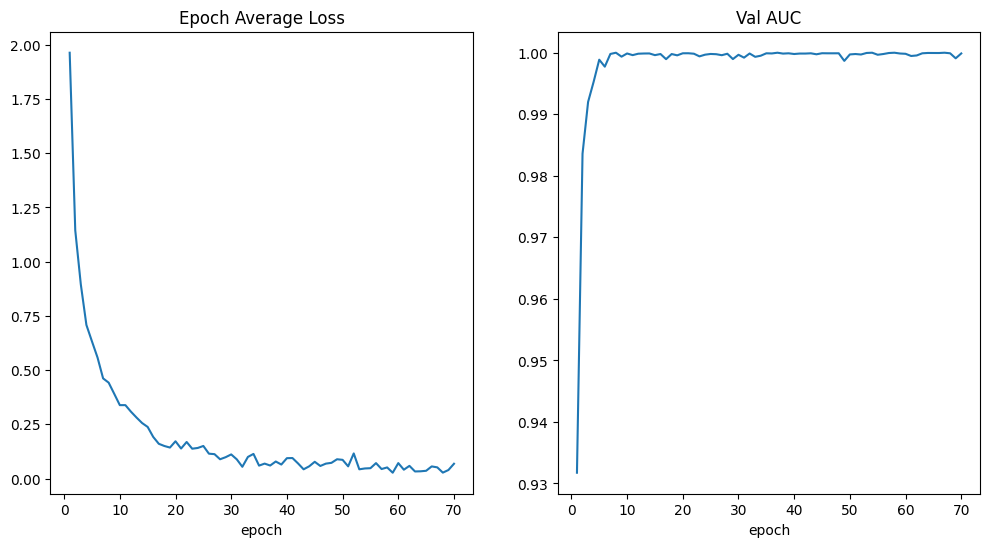

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [15]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.61 MB
Max VRAM used during training: 237.87 MB


### Evaluation

In [16]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [17]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.62 MB
Max VRAM used during training: 237.87 MB


In [18]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [19]:
import pandas as pd
df = pd.DataFrame(report).transpose()
df.to_csv(f'axial_full_pretrained_seed{seed}.csv')

In [20]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.7302    0.6765    0.7023        68
           2     0.6866    0.6667    0.6765        69
           3     0.7368    0.8615    0.7943        65
           4     0.7857    0.8462    0.8148        65
           5     0.8493    0.9394    0.8921        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9474    0.7826    0.8571        69
          10     0.8615    0.8116    0.8358        69

    accuracy                         0.8393       610
   macro avg     0.8699    0.8648    0.8656       610
weighted avg     0.8425    0.8393    0.8388       610



## Unpretrained

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1
auc_metric = ROCAUCMetric()

In [22]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70
epoch 1 average loss: 1.7959


Epochs:   1%|▏         | 1/70 [00:17<20:30, 17.83s/it]

1
saved new best metric model
current epoch: 1 current AUC: 0.9800 current accuracy: 0.8261 best AUC: 0.9800 at epoch: 1
----------
epoch 2/70
epoch 2 average loss: 1.0269


Epochs:   3%|▎         | 2/70 [00:35<20:08, 17.77s/it]

1
saved new best metric model
current epoch: 2 current AUC: 0.9985 current accuracy: 0.9441 best AUC: 0.9985 at epoch: 2
----------
epoch 3/70
epoch 3 average loss: 0.7502


Epochs:   4%|▍         | 3/70 [00:53<19:53, 17.81s/it]

1
saved new best metric model
current epoch: 3 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 3
----------
epoch 4/70
epoch 4 average loss: 0.6159


Epochs:   6%|▌         | 4/70 [01:10<19:25, 17.66s/it]

1
saved new best metric model
current epoch: 4 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 5/70
epoch 5 average loss: 0.5658


Epochs:   7%|▋         | 5/70 [01:28<19:07, 17.66s/it]

1
current epoch: 5 current AUC: 0.9998 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 4
----------
epoch 6/70
epoch 6 average loss: 0.4749


Epochs:   9%|▊         | 6/70 [01:46<18:51, 17.68s/it]

1
current epoch: 6 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 4
----------
epoch 7/70
epoch 7 average loss: 0.4333


Epochs:  10%|█         | 7/70 [02:03<18:31, 17.65s/it]

1
current epoch: 7 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 8/70
epoch 8 average loss: 0.3808


Epochs:  11%|█▏        | 8/70 [02:21<18:11, 17.60s/it]

1
current epoch: 8 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 4
----------
epoch 9/70
epoch 9 average loss: 0.3697


Epochs:  13%|█▎        | 9/70 [02:38<17:50, 17.55s/it]

1
current epoch: 9 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 4
----------
epoch 10/70
epoch 10 average loss: 0.3427


Epochs:  14%|█▍        | 10/70 [02:56<17:35, 17.60s/it]

1
current epoch: 10 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 11/70
epoch 11 average loss: 0.3028


Epochs:  16%|█▌        | 11/70 [03:13<17:15, 17.56s/it]

1
current epoch: 11 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 4
----------
epoch 12/70
epoch 12 average loss: 0.2736


Epochs:  17%|█▋        | 12/70 [03:31<16:59, 17.58s/it]

1
current epoch: 12 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 13/70
epoch 13 average loss: 0.2147


Epochs:  19%|█▊        | 13/70 [03:49<16:47, 17.68s/it]

1
current epoch: 13 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 4
----------
epoch 14/70
epoch 14 average loss: 0.1787


Epochs:  20%|██        | 14/70 [04:07<16:28, 17.66s/it]

1
current epoch: 14 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 15/70
epoch 15 average loss: 0.2178


Epochs:  21%|██▏       | 15/70 [04:24<16:08, 17.60s/it]

1
current epoch: 15 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 16/70
epoch 16 average loss: 0.1948


Epochs:  23%|██▎       | 16/70 [04:42<15:50, 17.60s/it]

1
current epoch: 16 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 17/70
epoch 17 average loss: 0.1964


Epochs:  24%|██▍       | 17/70 [04:59<15:31, 17.58s/it]

1
current epoch: 17 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 18/70
epoch 18 average loss: 0.1583


Epochs:  26%|██▌       | 18/70 [05:17<15:11, 17.53s/it]

1
current epoch: 18 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 19/70
epoch 19 average loss: 0.1181


Epochs:  27%|██▋       | 19/70 [05:34<14:53, 17.52s/it]

1
current epoch: 19 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 20/70
epoch 20 average loss: 0.1704


Epochs:  29%|██▊       | 20/70 [05:51<14:31, 17.43s/it]

1
current epoch: 20 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 21/70
epoch 21 average loss: 0.1446


Epochs:  30%|███       | 21/70 [06:09<14:14, 17.43s/it]

1
current epoch: 21 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 4
----------
epoch 22/70
epoch 22 average loss: 0.1618


Epochs:  31%|███▏      | 22/70 [06:26<14:00, 17.50s/it]

1
current epoch: 22 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 23/70
epoch 23 average loss: 0.1360


Epochs:  33%|███▎      | 23/70 [06:44<13:45, 17.57s/it]

1
current epoch: 23 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 24/70
epoch 24 average loss: 0.1365


Epochs:  34%|███▍      | 24/70 [07:02<13:27, 17.55s/it]

1
current epoch: 24 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 25/70
epoch 25 average loss: 0.1032


Epochs:  36%|███▌      | 25/70 [07:19<13:12, 17.61s/it]

1
current epoch: 25 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 26/70
epoch 26 average loss: 0.1028


Epochs:  37%|███▋      | 26/70 [07:37<12:55, 17.63s/it]

1
current epoch: 26 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 27/70
epoch 27 average loss: 0.0819


Epochs:  39%|███▊      | 27/70 [07:54<12:35, 17.58s/it]

1
current epoch: 27 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 28/70
epoch 28 average loss: 0.0987


Epochs:  40%|████      | 28/70 [08:12<12:18, 17.59s/it]

1
current epoch: 28 current AUC: 0.9999 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 4
----------
epoch 29/70
epoch 29 average loss: 0.1036


Epochs:  41%|████▏     | 29/70 [08:29<11:58, 17.52s/it]

1
current epoch: 29 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 4
----------
epoch 30/70
epoch 30 average loss: 0.0783


Epochs:  43%|████▎     | 30/70 [08:47<11:38, 17.47s/it]

1
current epoch: 30 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 4
----------
epoch 31/70
epoch 31 average loss: 0.0792


Epochs:  44%|████▍     | 31/70 [09:04<11:18, 17.41s/it]

1
current epoch: 31 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 32/70
epoch 32 average loss: 0.1134


Epochs:  46%|████▌     | 32/70 [09:22<11:03, 17.47s/it]

1
current epoch: 32 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 33/70
epoch 33 average loss: 0.0693


Epochs:  47%|████▋     | 33/70 [09:39<10:47, 17.51s/it]

1
current epoch: 33 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 34/70
epoch 34 average loss: 0.0592


Epochs:  49%|████▊     | 34/70 [09:57<10:31, 17.54s/it]

1
current epoch: 34 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 35/70
epoch 35 average loss: 0.0481


Epochs:  50%|█████     | 35/70 [10:14<10:13, 17.54s/it]

1
current epoch: 35 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 36/70
epoch 36 average loss: 0.0581


Epochs:  51%|█████▏    | 36/70 [10:32<09:57, 17.57s/it]

1
current epoch: 36 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 37/70
epoch 37 average loss: 0.0923


Epochs:  53%|█████▎    | 37/70 [10:50<09:38, 17.54s/it]

1
current epoch: 37 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 38/70
epoch 38 average loss: 0.0849


Epochs:  54%|█████▍    | 38/70 [11:07<09:21, 17.54s/it]

1
current epoch: 38 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 39/70
epoch 39 average loss: 0.1009


Epochs:  56%|█████▌    | 39/70 [11:25<09:04, 17.56s/it]

1
current epoch: 39 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 40/70
epoch 40 average loss: 0.0834


Epochs:  57%|█████▋    | 40/70 [11:42<08:46, 17.55s/it]

1
current epoch: 40 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 4
----------
epoch 41/70
epoch 41 average loss: 0.0903


Epochs:  59%|█████▊    | 41/70 [12:00<08:31, 17.65s/it]

1
current epoch: 41 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 42/70
epoch 42 average loss: 0.0513


Epochs:  60%|██████    | 42/70 [12:18<08:13, 17.64s/it]

1
current epoch: 42 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 43/70
epoch 43 average loss: 0.0433


Epochs:  61%|██████▏   | 43/70 [12:35<07:56, 17.63s/it]

1
current epoch: 43 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 44/70
epoch 44 average loss: 0.0519


Epochs:  63%|██████▎   | 44/70 [12:53<07:37, 17.60s/it]

1
current epoch: 44 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 45/70
epoch 45 average loss: 0.0828


Epochs:  64%|██████▍   | 45/70 [13:11<07:20, 17.61s/it]

1
current epoch: 45 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 46/70
epoch 46 average loss: 0.0508


Epochs:  66%|██████▌   | 46/70 [13:28<07:03, 17.63s/it]

1
current epoch: 46 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 47/70
epoch 47 average loss: 0.0574


Epochs:  67%|██████▋   | 47/70 [13:46<06:47, 17.70s/it]

1
current epoch: 47 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 48/70
epoch 48 average loss: 0.0623


Epochs:  69%|██████▊   | 48/70 [14:04<06:29, 17.71s/it]

1
current epoch: 48 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 49/70
epoch 49 average loss: 0.0931


Epochs:  70%|███████   | 49/70 [14:21<06:11, 17.68s/it]

1
current epoch: 49 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 4
----------
epoch 50/70
epoch 50 average loss: 0.0715


Epochs:  71%|███████▏  | 50/70 [14:39<05:52, 17.60s/it]

1
current epoch: 50 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 51/70
epoch 51 average loss: 0.0588


Epochs:  73%|███████▎  | 51/70 [14:56<05:34, 17.62s/it]

1
current epoch: 51 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 52/70
epoch 52 average loss: 0.0685


Epochs:  74%|███████▍  | 52/70 [15:14<05:17, 17.61s/it]

1
current epoch: 52 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 53/70
epoch 53 average loss: 0.0485


Epochs:  76%|███████▌  | 53/70 [15:32<05:01, 17.71s/it]

1
current epoch: 53 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 54/70
epoch 54 average loss: 0.0646


Epochs:  77%|███████▋  | 54/70 [15:50<04:43, 17.70s/it]

1
current epoch: 54 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 55/70
epoch 55 average loss: 0.0366


Epochs:  79%|███████▊  | 55/70 [16:07<04:25, 17.71s/it]

1
current epoch: 55 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 4
----------
epoch 56/70
epoch 56 average loss: 0.0549


Epochs:  80%|████████  | 56/70 [16:25<04:06, 17.63s/it]

1
current epoch: 56 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 57/70
epoch 57 average loss: 0.0547


Epochs:  81%|████████▏ | 57/70 [16:43<03:49, 17.65s/it]

1
current epoch: 57 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 58/70
epoch 58 average loss: 0.0401


Epochs:  83%|████████▎ | 58/70 [17:01<03:33, 17.75s/it]

1
current epoch: 58 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 59/70
epoch 59 average loss: 0.0396


Epochs:  84%|████████▍ | 59/70 [17:18<03:14, 17.72s/it]

1
current epoch: 59 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 4
----------
epoch 60/70
epoch 60 average loss: 0.0956


Epochs:  86%|████████▌ | 60/70 [17:36<02:56, 17.63s/it]

1
current epoch: 60 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 61/70
epoch 61 average loss: 0.0633


Epochs:  87%|████████▋ | 61/70 [17:54<02:39, 17.78s/it]

1
current epoch: 61 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 62/70
epoch 62 average loss: 0.0363


Epochs:  89%|████████▊ | 62/70 [18:11<02:21, 17.69s/it]

1
current epoch: 62 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 4
----------
epoch 63/70
epoch 63 average loss: 0.0525


Epochs:  90%|█████████ | 63/70 [18:29<02:03, 17.68s/it]

1
current epoch: 63 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 64/70
epoch 64 average loss: 0.0362


Epochs:  91%|█████████▏| 64/70 [18:47<01:45, 17.66s/it]

1
current epoch: 64 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 65/70
epoch 65 average loss: 0.0470


Epochs:  93%|█████████▎| 65/70 [19:04<01:28, 17.69s/it]

1
current epoch: 65 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 4
----------
epoch 66/70
epoch 66 average loss: 0.0280


Epochs:  94%|█████████▍| 66/70 [19:22<01:10, 17.63s/it]

1
current epoch: 66 current AUC: 1.0000 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 4
----------
epoch 67/70
epoch 67 average loss: 0.0428


Epochs:  96%|█████████▌| 67/70 [19:39<00:52, 17.62s/it]

1
current epoch: 67 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 4
----------
epoch 68/70
epoch 68 average loss: 0.0670


Epochs:  97%|█████████▋| 68/70 [19:57<00:35, 17.68s/it]

1
current epoch: 68 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 69/70
epoch 69 average loss: 0.0470


Epochs:  99%|█████████▊| 69/70 [20:15<00:17, 17.64s/it]

1
current epoch: 69 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 4
----------
epoch 70/70
epoch 70 average loss: 0.0531


Epochs: 100%|██████████| 70/70 [20:32<00:00, 17.61s/it]

1
current epoch: 70 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 4
train completed, best_metric: 1.0000 at epoch: 4


In [23]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1232.88 seconds
CPU time used: 14779.40 seconds
Memory used: 491.09 MB
GPU Memory Used: 193.52 MB
Max GPU Memory Used: 251.94 MB


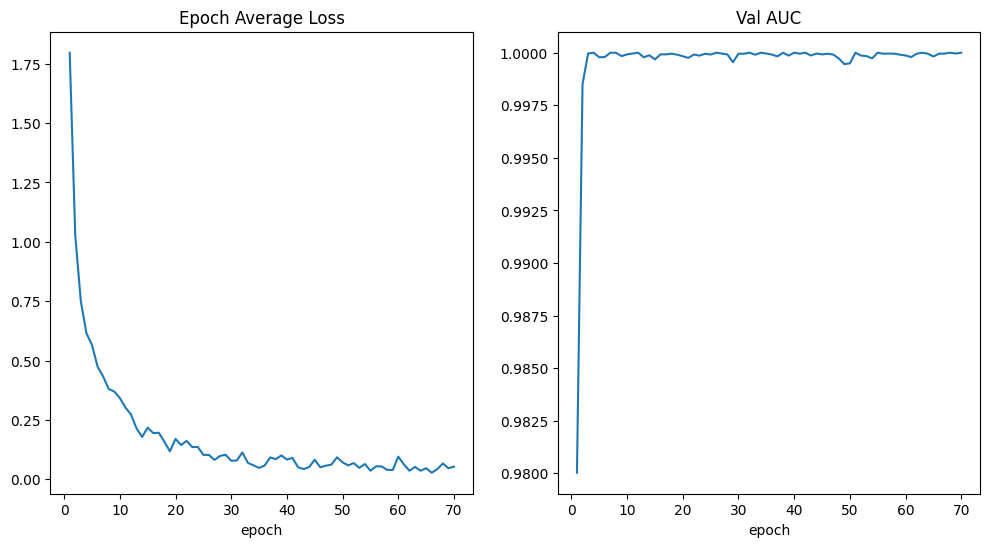

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [25]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 193.51 MB
Max VRAM used during training: 251.94 MB


### Evaluation

In [26]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [27]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [28]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'axial_full_unpretrained_seed{seed}.csv')

In [29]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9565    0.9778        69
           1     0.5196    0.7794    0.6235        68
           2     0.6452    0.5797    0.6107        69
           3     0.6875    0.6769    0.6822        65
           4     0.7286    0.7846    0.7556        65
           5     1.0000    0.7879    0.8814        66
           6     1.0000    0.8214    0.9020        28
           7     0.9130    1.0000    0.9545        21
           8     0.8750    1.0000    0.9333        21
           9     0.7250    0.8406    0.7785        69
          10     0.9545    0.6087    0.7434        69

    accuracy                         0.7721       610
   macro avg     0.8226    0.8033    0.8039       610
weighted avg     0.8005    0.7721    0.7763       610



In [30]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 193.51 MB
Max VRAM used during training: 251.94 MB


# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70
epoch 1 average loss: 1.9301


Epochs:   1%|▏         | 1/70 [00:17<20:35, 17.90s/it]

1
saved new best metric model
current epoch: 1 current AUC: 0.9278 current accuracy: 0.5404 best AUC: 0.9278 at epoch: 1
----------
epoch 2/70
epoch 2 average loss: 1.2887


Epochs:   3%|▎         | 2/70 [00:35<20:07, 17.76s/it]

1
saved new best metric model
current epoch: 2 current AUC: 0.9608 current accuracy: 0.6273 best AUC: 0.9608 at epoch: 2
----------
epoch 3/70
epoch 3 average loss: 1.0154


Epochs:   4%|▍         | 3/70 [00:53<19:54, 17.83s/it]

1
saved new best metric model
current epoch: 3 current AUC: 0.9803 current accuracy: 0.8199 best AUC: 0.9803 at epoch: 3
----------
epoch 4/70
epoch 4 average loss: 0.8847


Epochs:   6%|▌         | 4/70 [01:11<19:35, 17.82s/it]

1
saved new best metric model
current epoch: 4 current AUC: 0.9861 current accuracy: 0.8075 best AUC: 0.9861 at epoch: 4
----------
epoch 5/70
epoch 5 average loss: 0.7528


Epochs:   7%|▋         | 5/70 [01:29<19:18, 17.82s/it]

1
saved new best metric model
current epoch: 5 current AUC: 0.9895 current accuracy: 0.8137 best AUC: 0.9895 at epoch: 5
----------
epoch 6/70
epoch 6 average loss: 0.6557


Epochs:   9%|▊         | 6/70 [01:46<18:56, 17.76s/it]

1
saved new best metric model
current epoch: 6 current AUC: 0.9907 current accuracy: 0.8634 best AUC: 0.9907 at epoch: 6
----------
epoch 7/70
epoch 7 average loss: 0.6166


Epochs:  10%|█         | 7/70 [02:04<18:37, 17.73s/it]

1
saved new best metric model
current epoch: 7 current AUC: 0.9916 current accuracy: 0.8509 best AUC: 0.9916 at epoch: 7
----------
epoch 8/70
epoch 8 average loss: 0.5660


Epochs:  11%|█▏        | 8/70 [02:22<18:16, 17.69s/it]

1
saved new best metric model
current epoch: 8 current AUC: 0.9922 current accuracy: 0.9006 best AUC: 0.9922 at epoch: 8
----------
epoch 9/70
epoch 9 average loss: 0.5212


Epochs:  13%|█▎        | 9/70 [02:39<18:02, 17.74s/it]

1
current epoch: 9 current AUC: 0.9861 current accuracy: 0.8509 best AUC: 0.9922 at epoch: 8
----------
epoch 10/70
epoch 10 average loss: 0.4931


Epochs:  14%|█▍        | 10/70 [02:57<17:42, 17.71s/it]

1
current epoch: 10 current AUC: 0.9896 current accuracy: 0.8634 best AUC: 0.9922 at epoch: 8
----------
epoch 11/70
epoch 11 average loss: 0.4347


Epochs:  16%|█▌        | 11/70 [03:15<17:23, 17.69s/it]

1
saved new best metric model
current epoch: 11 current AUC: 0.9941 current accuracy: 0.8820 best AUC: 0.9941 at epoch: 11
----------
epoch 12/70
epoch 12 average loss: 0.4362


Epochs:  17%|█▋        | 12/70 [03:32<17:04, 17.66s/it]

1
current epoch: 12 current AUC: 0.9838 current accuracy: 0.8012 best AUC: 0.9941 at epoch: 11
----------
epoch 13/70
epoch 13 average loss: 0.3902


Epochs:  19%|█▊        | 13/70 [03:50<16:44, 17.63s/it]

1
current epoch: 13 current AUC: 0.9872 current accuracy: 0.8385 best AUC: 0.9941 at epoch: 11
----------
epoch 14/70
epoch 14 average loss: 0.3710


Epochs:  20%|██        | 14/70 [04:07<16:25, 17.60s/it]

1
current epoch: 14 current AUC: 0.9923 current accuracy: 0.8820 best AUC: 0.9941 at epoch: 11
----------
epoch 15/70
epoch 15 average loss: 0.3721


Epochs:  21%|██▏       | 15/70 [04:25<16:09, 17.64s/it]

1
current epoch: 15 current AUC: 0.9874 current accuracy: 0.8385 best AUC: 0.9941 at epoch: 11
----------
epoch 16/70
epoch 16 average loss: 0.3054


Epochs:  23%|██▎       | 16/70 [04:43<15:51, 17.61s/it]

1
current epoch: 16 current AUC: 0.9849 current accuracy: 0.8509 best AUC: 0.9941 at epoch: 11
----------
epoch 17/70
epoch 17 average loss: 0.3219


Epochs:  24%|██▍       | 17/70 [05:00<15:34, 17.63s/it]

1
current epoch: 17 current AUC: 0.9914 current accuracy: 0.8820 best AUC: 0.9941 at epoch: 11
----------
epoch 18/70
epoch 18 average loss: 0.2921


Epochs:  26%|██▌       | 18/70 [05:18<15:18, 17.67s/it]

1
current epoch: 18 current AUC: 0.9779 current accuracy: 0.7888 best AUC: 0.9941 at epoch: 11
----------
epoch 19/70
epoch 19 average loss: 0.2801


Epochs:  27%|██▋       | 19/70 [05:36<15:03, 17.71s/it]

1
saved new best metric model
current epoch: 19 current AUC: 0.9971 current accuracy: 0.9068 best AUC: 0.9971 at epoch: 19
----------
epoch 20/70
epoch 20 average loss: 0.2979


Epochs:  29%|██▊       | 20/70 [05:54<14:49, 17.78s/it]

1
current epoch: 20 current AUC: 0.9908 current accuracy: 0.8696 best AUC: 0.9971 at epoch: 19
----------
epoch 21/70
epoch 21 average loss: 0.2720


Epochs:  30%|███       | 21/70 [06:11<14:27, 17.71s/it]

1
current epoch: 21 current AUC: 0.9784 current accuracy: 0.8137 best AUC: 0.9971 at epoch: 19
----------
epoch 22/70
epoch 22 average loss: 0.2714


Epochs:  31%|███▏      | 22/70 [06:29<14:07, 17.65s/it]

1
current epoch: 22 current AUC: 0.9892 current accuracy: 0.8509 best AUC: 0.9971 at epoch: 19
----------
epoch 23/70
epoch 23 average loss: 0.2693


Epochs:  33%|███▎      | 23/70 [06:46<13:48, 17.62s/it]

1
current epoch: 23 current AUC: 0.9927 current accuracy: 0.8696 best AUC: 0.9971 at epoch: 19
----------
epoch 24/70
epoch 24 average loss: 0.2605


Epochs:  34%|███▍      | 24/70 [07:04<13:32, 17.66s/it]

1
current epoch: 24 current AUC: 0.9933 current accuracy: 0.8758 best AUC: 0.9971 at epoch: 19
----------
epoch 25/70
epoch 25 average loss: 0.2561


Epochs:  36%|███▌      | 25/70 [07:22<13:13, 17.64s/it]

1
current epoch: 25 current AUC: 0.9920 current accuracy: 0.8820 best AUC: 0.9971 at epoch: 19
----------
epoch 26/70
epoch 26 average loss: 0.2023


Epochs:  37%|███▋      | 26/70 [07:39<12:56, 17.66s/it]

1
current epoch: 26 current AUC: 0.9892 current accuracy: 0.8820 best AUC: 0.9971 at epoch: 19
----------
epoch 27/70
epoch 27 average loss: 0.2410


Epochs:  39%|███▊      | 27/70 [07:57<12:40, 17.68s/it]

1
current epoch: 27 current AUC: 0.9833 current accuracy: 0.8634 best AUC: 0.9971 at epoch: 19
----------
epoch 28/70
epoch 28 average loss: 0.1992


Epochs:  40%|████      | 28/70 [08:15<12:20, 17.63s/it]

1
current epoch: 28 current AUC: 0.9916 current accuracy: 0.8882 best AUC: 0.9971 at epoch: 19
----------
epoch 29/70
epoch 29 average loss: 0.1846


Epochs:  41%|████▏     | 29/70 [08:32<12:03, 17.64s/it]

1
current epoch: 29 current AUC: 0.9943 current accuracy: 0.8944 best AUC: 0.9971 at epoch: 19
----------
epoch 30/70
epoch 30 average loss: 0.2036


Epochs:  43%|████▎     | 30/70 [08:50<11:45, 17.63s/it]

1
current epoch: 30 current AUC: 0.9869 current accuracy: 0.8758 best AUC: 0.9971 at epoch: 19
----------
epoch 31/70
epoch 31 average loss: 0.1878


Epochs:  44%|████▍     | 31/70 [09:08<11:26, 17.61s/it]

1
current epoch: 31 current AUC: 0.9908 current accuracy: 0.8758 best AUC: 0.9971 at epoch: 19
----------
epoch 32/70
epoch 32 average loss: 0.1904


Epochs:  46%|████▌     | 32/70 [09:25<11:07, 17.57s/it]

1
current epoch: 32 current AUC: 0.9960 current accuracy: 0.8882 best AUC: 0.9971 at epoch: 19
----------
epoch 33/70
epoch 33 average loss: 0.1875


Epochs:  47%|████▋     | 33/70 [09:43<10:49, 17.56s/it]

1
current epoch: 33 current AUC: 0.9918 current accuracy: 0.8758 best AUC: 0.9971 at epoch: 19
----------
epoch 34/70
epoch 34 average loss: 0.1566


Epochs:  49%|████▊     | 34/70 [10:00<10:30, 17.52s/it]

1
current epoch: 34 current AUC: 0.9910 current accuracy: 0.8882 best AUC: 0.9971 at epoch: 19
----------
epoch 35/70
epoch 35 average loss: 0.1819


Epochs:  50%|█████     | 35/70 [10:18<10:15, 17.58s/it]

1
current epoch: 35 current AUC: 0.9884 current accuracy: 0.8634 best AUC: 0.9971 at epoch: 19
----------
epoch 36/70
epoch 36 average loss: 0.1803


Epochs:  51%|█████▏    | 36/70 [10:36<10:01, 17.69s/it]

1
current epoch: 36 current AUC: 0.9858 current accuracy: 0.8385 best AUC: 0.9971 at epoch: 19
----------
epoch 37/70
epoch 37 average loss: 0.1636


Epochs:  53%|█████▎    | 37/70 [10:53<09:43, 17.68s/it]

1
current epoch: 37 current AUC: 0.9875 current accuracy: 0.8696 best AUC: 0.9971 at epoch: 19
----------
epoch 38/70
epoch 38 average loss: 0.1867


Epochs:  54%|█████▍    | 38/70 [11:11<09:25, 17.67s/it]

1
current epoch: 38 current AUC: 0.9899 current accuracy: 0.8634 best AUC: 0.9971 at epoch: 19
----------
epoch 39/70
epoch 39 average loss: 0.1510


Epochs:  56%|█████▌    | 39/70 [11:28<09:05, 17.59s/it]

1
current epoch: 39 current AUC: 0.9953 current accuracy: 0.9130 best AUC: 0.9971 at epoch: 19
----------
epoch 40/70
epoch 40 average loss: 0.1441


Epochs:  57%|█████▋    | 40/70 [11:46<08:46, 17.54s/it]

1
current epoch: 40 current AUC: 0.9957 current accuracy: 0.8696 best AUC: 0.9971 at epoch: 19
----------
epoch 41/70
epoch 41 average loss: 0.1639


Epochs:  59%|█████▊    | 41/70 [12:03<08:29, 17.58s/it]

1
current epoch: 41 current AUC: 0.9963 current accuracy: 0.9068 best AUC: 0.9971 at epoch: 19
----------
epoch 42/70
epoch 42 average loss: 0.1520


Epochs:  60%|██████    | 42/70 [12:21<08:14, 17.66s/it]

1
current epoch: 42 current AUC: 0.9958 current accuracy: 0.9130 best AUC: 0.9971 at epoch: 19
----------
epoch 43/70
epoch 43 average loss: 0.1723


Epochs:  61%|██████▏   | 43/70 [12:39<07:57, 17.68s/it]

1
current epoch: 43 current AUC: 0.9879 current accuracy: 0.8571 best AUC: 0.9971 at epoch: 19
----------
epoch 44/70
epoch 44 average loss: 0.1387


Epochs:  63%|██████▎   | 44/70 [12:57<07:40, 17.70s/it]

1
saved new best metric model
current epoch: 44 current AUC: 0.9975 current accuracy: 0.9130 best AUC: 0.9975 at epoch: 44
----------
epoch 45/70
epoch 45 average loss: 0.1335


Epochs:  64%|██████▍   | 45/70 [13:14<07:22, 17.70s/it]

1
current epoch: 45 current AUC: 0.9872 current accuracy: 0.8571 best AUC: 0.9975 at epoch: 44
----------
epoch 46/70
epoch 46 average loss: 0.1305


Epochs:  66%|██████▌   | 46/70 [13:32<07:04, 17.70s/it]

1
current epoch: 46 current AUC: 0.9957 current accuracy: 0.9317 best AUC: 0.9975 at epoch: 44
----------
epoch 47/70
epoch 47 average loss: 0.1256


Epochs:  67%|██████▋   | 47/70 [13:50<06:46, 17.65s/it]

1
current epoch: 47 current AUC: 0.9908 current accuracy: 0.8696 best AUC: 0.9975 at epoch: 44
----------
epoch 48/70
epoch 48 average loss: 0.1024


Epochs:  69%|██████▊   | 48/70 [14:07<06:28, 17.64s/it]

1
current epoch: 48 current AUC: 0.9914 current accuracy: 0.9006 best AUC: 0.9975 at epoch: 44
----------
epoch 49/70
epoch 49 average loss: 0.1100


Epochs:  70%|███████   | 49/70 [14:25<06:11, 17.68s/it]

1
current epoch: 49 current AUC: 0.9919 current accuracy: 0.9006 best AUC: 0.9975 at epoch: 44
----------
epoch 50/70
epoch 50 average loss: 0.1330


Epochs:  71%|███████▏  | 50/70 [14:43<05:53, 17.67s/it]

1
current epoch: 50 current AUC: 0.9907 current accuracy: 0.8882 best AUC: 0.9975 at epoch: 44
----------
epoch 51/70
epoch 51 average loss: 0.1044


Epochs:  73%|███████▎  | 51/70 [15:01<05:36, 17.73s/it]

1
current epoch: 51 current AUC: 0.9806 current accuracy: 0.7826 best AUC: 0.9975 at epoch: 44
----------
epoch 52/70
epoch 52 average loss: 0.0880


Epochs:  74%|███████▍  | 52/70 [15:18<05:19, 17.75s/it]

1
current epoch: 52 current AUC: 0.9908 current accuracy: 0.8758 best AUC: 0.9975 at epoch: 44
----------
epoch 53/70
epoch 53 average loss: 0.0966


Epochs:  76%|███████▌  | 53/70 [15:36<05:00, 17.69s/it]

1
current epoch: 53 current AUC: 0.9963 current accuracy: 0.9006 best AUC: 0.9975 at epoch: 44
----------
epoch 54/70
epoch 54 average loss: 0.0998


Epochs:  77%|███████▋  | 54/70 [15:54<04:43, 17.70s/it]

1
current epoch: 54 current AUC: 0.9962 current accuracy: 0.9130 best AUC: 0.9975 at epoch: 44
----------
epoch 55/70
epoch 55 average loss: 0.1136


Epochs:  79%|███████▊  | 55/70 [16:11<04:24, 17.66s/it]

1
current epoch: 55 current AUC: 0.9938 current accuracy: 0.9006 best AUC: 0.9975 at epoch: 44
----------
epoch 56/70
epoch 56 average loss: 0.1375


Epochs:  80%|████████  | 56/70 [16:29<04:06, 17.61s/it]

1
current epoch: 56 current AUC: 0.9928 current accuracy: 0.9068 best AUC: 0.9975 at epoch: 44
----------
epoch 57/70
epoch 57 average loss: 0.1054


Epochs:  81%|████████▏ | 57/70 [16:46<03:49, 17.62s/it]

1
current epoch: 57 current AUC: 0.9890 current accuracy: 0.8571 best AUC: 0.9975 at epoch: 44
----------
epoch 58/70
epoch 58 average loss: 0.0997


Epochs:  83%|████████▎ | 58/70 [17:04<03:31, 17.61s/it]

1
saved new best metric model
current epoch: 58 current AUC: 0.9981 current accuracy: 0.9565 best AUC: 0.9981 at epoch: 58
----------
epoch 59/70
epoch 59 average loss: 0.0976


Epochs:  84%|████████▍ | 59/70 [17:22<03:14, 17.64s/it]

1
current epoch: 59 current AUC: 0.9964 current accuracy: 0.9317 best AUC: 0.9981 at epoch: 58
----------
epoch 60/70
epoch 60 average loss: 0.0778


Epochs:  86%|████████▌ | 60/70 [17:39<02:56, 17.61s/it]

1
current epoch: 60 current AUC: 0.9953 current accuracy: 0.9130 best AUC: 0.9981 at epoch: 58
----------
epoch 61/70
epoch 61 average loss: 0.0887


Epochs:  87%|████████▋ | 61/70 [17:57<02:37, 17.54s/it]

1
current epoch: 61 current AUC: 0.9919 current accuracy: 0.8944 best AUC: 0.9981 at epoch: 58
----------
epoch 62/70
epoch 62 average loss: 0.1179


Epochs:  89%|████████▊ | 62/70 [18:14<02:20, 17.53s/it]

1
current epoch: 62 current AUC: 0.9962 current accuracy: 0.9006 best AUC: 0.9981 at epoch: 58
----------
epoch 63/70
epoch 63 average loss: 0.1352


Epochs:  90%|█████████ | 63/70 [18:32<02:03, 17.60s/it]

1
current epoch: 63 current AUC: 0.9980 current accuracy: 0.9503 best AUC: 0.9981 at epoch: 58
----------
epoch 64/70
epoch 64 average loss: 0.1186


Epochs:  91%|█████████▏| 64/70 [18:50<01:45, 17.65s/it]

1
current epoch: 64 current AUC: 0.9864 current accuracy: 0.8261 best AUC: 0.9981 at epoch: 58
----------
epoch 65/70
epoch 65 average loss: 0.0858


Epochs:  93%|█████████▎| 65/70 [19:07<01:28, 17.68s/it]

1
current epoch: 65 current AUC: 0.9930 current accuracy: 0.8882 best AUC: 0.9981 at epoch: 58
----------
epoch 66/70
epoch 66 average loss: 0.0958


Epochs:  94%|█████████▍| 66/70 [19:25<01:10, 17.58s/it]

1
current epoch: 66 current AUC: 0.9973 current accuracy: 0.9193 best AUC: 0.9981 at epoch: 58
----------
epoch 67/70
epoch 67 average loss: 0.0947


Epochs:  96%|█████████▌| 67/70 [19:42<00:52, 17.61s/it]

1
current epoch: 67 current AUC: 0.9920 current accuracy: 0.8634 best AUC: 0.9981 at epoch: 58
----------
epoch 68/70
epoch 68 average loss: 0.0664


Epochs:  97%|█████████▋| 68/70 [20:00<00:35, 17.57s/it]

1
current epoch: 68 current AUC: 0.9918 current accuracy: 0.8820 best AUC: 0.9981 at epoch: 58
----------
epoch 69/70
epoch 69 average loss: 0.0956


Epochs:  99%|█████████▊| 69/70 [20:18<00:17, 17.62s/it]

1
current epoch: 69 current AUC: 0.9858 current accuracy: 0.8137 best AUC: 0.9981 at epoch: 58
----------
epoch 70/70
epoch 70 average loss: 0.0654


Epochs: 100%|██████████| 70/70 [20:35<00:00, 17.65s/it]

1
current epoch: 70 current AUC: 0.9887 current accuracy: 0.8509 best AUC: 0.9981 at epoch: 58
train completed, best_metric: 0.9981 at epoch: 58


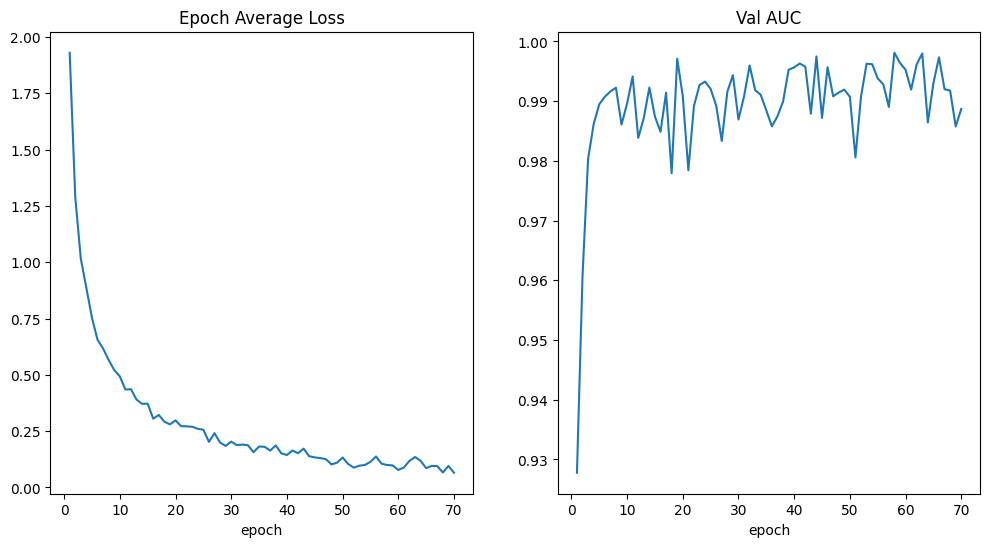

In [33]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [34]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1235.64 seconds
CPU time used: 14811.27 seconds
Memory used: 73.03 MB
GPU Memory Used: 193.75 MB
Max GPU Memory Used: 237.89 MB


In [35]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 193.75 MB
Max VRAM used during training: 237.89 MB


### Evaluation

In [36]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [37]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     0.7407    0.5882    0.6557        68
           2     0.5833    0.6087    0.5957        69
           3     0.7018    0.6154    0.6557        65
           4     0.6389    0.7077    0.6715        65
           5     0.8000    0.9697    0.8767        66
           6     1.0000    1.0000    1.0000        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8732    0.8986    0.8857        69
          10     0.9692    0.9130    0.9403        69

    accuracy                         0.8131       610
   macro avg     0.8461    0.8456    0.8438       610
weighted avg     0.8143    0.8131    0.8112       610



In [38]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'coronal_full_pretrained_seed{seed}.csv')

In [39]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 193.74 MB
Max VRAM used during training: 237.89 MB


## Unpretrained

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1
auc_metric = ROCAUCMetric()

In [41]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70
epoch 1 average loss: 1.7648


Epochs:   1%|▏         | 1/70 [00:17<20:25, 17.76s/it]

1
saved new best metric model
current epoch: 1 current AUC: 0.9422 current accuracy: 0.4161 best AUC: 0.9422 at epoch: 1
----------
epoch 2/70
epoch 2 average loss: 1.1978


Epochs:   3%|▎         | 2/70 [00:35<20:01, 17.66s/it]

1
saved new best metric model
current epoch: 2 current AUC: 0.9842 current accuracy: 0.6149 best AUC: 0.9842 at epoch: 2
----------
epoch 3/70
epoch 3 average loss: 0.9734


Epochs:   4%|▍         | 3/70 [00:53<19:46, 17.71s/it]

1
current epoch: 3 current AUC: 0.9837 current accuracy: 0.7329 best AUC: 0.9842 at epoch: 2
----------
epoch 4/70
epoch 4 average loss: 0.8794


Epochs:   6%|▌         | 4/70 [01:10<19:29, 17.72s/it]

1
saved new best metric model
current epoch: 4 current AUC: 0.9850 current accuracy: 0.7950 best AUC: 0.9850 at epoch: 4
----------
epoch 5/70
epoch 5 average loss: 0.7155


Epochs:   7%|▋         | 5/70 [01:28<19:04, 17.61s/it]

1
saved new best metric model
current epoch: 5 current AUC: 0.9910 current accuracy: 0.7950 best AUC: 0.9910 at epoch: 5
----------
epoch 6/70
epoch 6 average loss: 0.6935


Epochs:   9%|▊         | 6/70 [01:45<18:47, 17.61s/it]

1
current epoch: 6 current AUC: 0.9872 current accuracy: 0.8509 best AUC: 0.9910 at epoch: 5
----------
epoch 7/70
epoch 7 average loss: 0.6468


Epochs:  10%|█         | 7/70 [02:03<18:29, 17.61s/it]

1
current epoch: 7 current AUC: 0.9836 current accuracy: 0.7826 best AUC: 0.9910 at epoch: 5
----------
epoch 8/70
epoch 8 average loss: 0.6275


Epochs:  11%|█▏        | 8/70 [02:21<18:10, 17.58s/it]

1
current epoch: 8 current AUC: 0.9830 current accuracy: 0.7516 best AUC: 0.9910 at epoch: 5
----------
epoch 9/70
epoch 9 average loss: 0.5480


Epochs:  13%|█▎        | 9/70 [02:38<17:57, 17.66s/it]

1
saved new best metric model
current epoch: 9 current AUC: 0.9923 current accuracy: 0.8509 best AUC: 0.9923 at epoch: 9
----------
epoch 10/70
epoch 10 average loss: 0.4988


Epochs:  14%|█▍        | 10/70 [02:56<17:40, 17.68s/it]

1
current epoch: 10 current AUC: 0.9846 current accuracy: 0.7081 best AUC: 0.9923 at epoch: 9
----------
epoch 11/70
epoch 11 average loss: 0.4729


Epochs:  16%|█▌        | 11/70 [03:14<17:19, 17.62s/it]

1
saved new best metric model
current epoch: 11 current AUC: 0.9949 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 11
----------
epoch 12/70
epoch 12 average loss: 0.3987


Epochs:  17%|█▋        | 12/70 [03:31<16:59, 17.58s/it]

1
current epoch: 12 current AUC: 0.9908 current accuracy: 0.8261 best AUC: 0.9949 at epoch: 11
----------
epoch 13/70
epoch 13 average loss: 0.4202


Epochs:  19%|█▊        | 13/70 [03:49<16:42, 17.59s/it]

1
current epoch: 13 current AUC: 0.9863 current accuracy: 0.7267 best AUC: 0.9949 at epoch: 11
----------
epoch 14/70
epoch 14 average loss: 0.3834


Epochs:  20%|██        | 14/70 [04:06<16:23, 17.57s/it]

1
current epoch: 14 current AUC: 0.9893 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 11
----------
epoch 15/70
epoch 15 average loss: 0.3583


Epochs:  21%|██▏       | 15/70 [04:24<16:08, 17.62s/it]

1
current epoch: 15 current AUC: 0.9877 current accuracy: 0.8261 best AUC: 0.9949 at epoch: 11
----------
epoch 16/70
epoch 16 average loss: 0.3043


Epochs:  23%|██▎       | 16/70 [04:41<15:50, 17.60s/it]

1
current epoch: 16 current AUC: 0.9853 current accuracy: 0.8199 best AUC: 0.9949 at epoch: 11
----------
epoch 17/70
epoch 17 average loss: 0.3230


Epochs:  24%|██▍       | 17/70 [04:59<15:30, 17.56s/it]

1
current epoch: 17 current AUC: 0.9896 current accuracy: 0.8571 best AUC: 0.9949 at epoch: 11
----------
epoch 18/70
epoch 18 average loss: 0.3011


Epochs:  26%|██▌       | 18/70 [05:17<15:16, 17.63s/it]

1
current epoch: 18 current AUC: 0.9905 current accuracy: 0.8509 best AUC: 0.9949 at epoch: 11
----------
epoch 19/70
epoch 19 average loss: 0.3069


Epochs:  27%|██▋       | 19/70 [05:34<14:54, 17.53s/it]

1
current epoch: 19 current AUC: 0.9835 current accuracy: 0.7578 best AUC: 0.9949 at epoch: 11
----------
epoch 20/70
epoch 20 average loss: 0.3275


Epochs:  29%|██▊       | 20/70 [05:52<14:40, 17.62s/it]

1
current epoch: 20 current AUC: 0.9872 current accuracy: 0.8571 best AUC: 0.9949 at epoch: 11
----------
epoch 21/70
epoch 21 average loss: 0.2708


Epochs:  30%|███       | 21/70 [06:10<14:24, 17.64s/it]

1
current epoch: 21 current AUC: 0.9946 current accuracy: 0.8820 best AUC: 0.9949 at epoch: 11
----------
epoch 22/70
epoch 22 average loss: 0.2389


Epochs:  31%|███▏      | 22/70 [06:27<14:10, 17.73s/it]

1
current epoch: 22 current AUC: 0.9839 current accuracy: 0.7888 best AUC: 0.9949 at epoch: 11
----------
epoch 23/70
epoch 23 average loss: 0.2110


Epochs:  33%|███▎      | 23/70 [06:45<13:50, 17.66s/it]

1
saved new best metric model
current epoch: 23 current AUC: 0.9958 current accuracy: 0.9006 best AUC: 0.9958 at epoch: 23
----------
epoch 24/70
epoch 24 average loss: 0.2509


Epochs:  34%|███▍      | 24/70 [07:03<13:32, 17.66s/it]

1
current epoch: 24 current AUC: 0.9924 current accuracy: 0.8385 best AUC: 0.9958 at epoch: 23
----------
epoch 25/70
epoch 25 average loss: 0.2260


Epochs:  36%|███▌      | 25/70 [07:20<13:13, 17.62s/it]

1
current epoch: 25 current AUC: 0.9898 current accuracy: 0.8385 best AUC: 0.9958 at epoch: 23
----------
epoch 26/70
epoch 26 average loss: 0.1892


Epochs:  37%|███▋      | 26/70 [07:38<12:52, 17.55s/it]

1
current epoch: 26 current AUC: 0.9955 current accuracy: 0.8696 best AUC: 0.9958 at epoch: 23
----------
epoch 27/70
epoch 27 average loss: 0.2753


Epochs:  39%|███▊      | 27/70 [07:55<12:35, 17.58s/it]

1
current epoch: 27 current AUC: 0.9922 current accuracy: 0.8509 best AUC: 0.9958 at epoch: 23
----------
epoch 28/70
epoch 28 average loss: 0.2475


Epochs:  40%|████      | 28/70 [08:13<12:17, 17.57s/it]

1
current epoch: 28 current AUC: 0.9936 current accuracy: 0.8634 best AUC: 0.9958 at epoch: 23
----------
epoch 29/70
epoch 29 average loss: 0.2148


Epochs:  41%|████▏     | 29/70 [08:30<12:00, 17.57s/it]

1
current epoch: 29 current AUC: 0.9881 current accuracy: 0.8199 best AUC: 0.9958 at epoch: 23
----------
epoch 30/70
epoch 30 average loss: 0.1828


Epochs:  43%|████▎     | 30/70 [08:48<11:42, 17.55s/it]

1
current epoch: 30 current AUC: 0.9856 current accuracy: 0.8447 best AUC: 0.9958 at epoch: 23
----------
epoch 31/70
epoch 31 average loss: 0.2143


Epochs:  44%|████▍     | 31/70 [09:05<11:22, 17.50s/it]

1
current epoch: 31 current AUC: 0.9902 current accuracy: 0.8571 best AUC: 0.9958 at epoch: 23
----------
epoch 32/70
epoch 32 average loss: 0.1829


Epochs:  46%|████▌     | 32/70 [09:23<11:05, 17.50s/it]

1
current epoch: 32 current AUC: 0.9929 current accuracy: 0.8696 best AUC: 0.9958 at epoch: 23
----------
epoch 33/70
epoch 33 average loss: 0.1400


Epochs:  47%|████▋     | 33/70 [09:40<10:46, 17.47s/it]

1
current epoch: 33 current AUC: 0.9921 current accuracy: 0.8820 best AUC: 0.9958 at epoch: 23
----------
epoch 34/70
epoch 34 average loss: 0.1802


Epochs:  49%|████▊     | 34/70 [09:58<10:29, 17.48s/it]

1
current epoch: 34 current AUC: 0.9942 current accuracy: 0.8820 best AUC: 0.9958 at epoch: 23
----------
epoch 35/70
epoch 35 average loss: 0.1461


Epochs:  50%|█████     | 35/70 [10:15<10:15, 17.58s/it]

1
current epoch: 35 current AUC: 0.9923 current accuracy: 0.8758 best AUC: 0.9958 at epoch: 23
----------
epoch 36/70
epoch 36 average loss: 0.1210


Epochs:  51%|█████▏    | 36/70 [10:33<09:55, 17.52s/it]

1
current epoch: 36 current AUC: 0.9890 current accuracy: 0.8447 best AUC: 0.9958 at epoch: 23
----------
epoch 37/70
epoch 37 average loss: 0.1296


Epochs:  53%|█████▎    | 37/70 [10:50<09:39, 17.55s/it]

1
current epoch: 37 current AUC: 0.9776 current accuracy: 0.7826 best AUC: 0.9958 at epoch: 23
----------
epoch 38/70
epoch 38 average loss: 0.1979


Epochs:  54%|█████▍    | 38/70 [11:08<09:22, 17.56s/it]

1
current epoch: 38 current AUC: 0.9862 current accuracy: 0.8261 best AUC: 0.9958 at epoch: 23
----------
epoch 39/70
epoch 39 average loss: 0.1808


Epochs:  56%|█████▌    | 39/70 [11:26<09:05, 17.61s/it]

1
current epoch: 39 current AUC: 0.9858 current accuracy: 0.8385 best AUC: 0.9958 at epoch: 23
----------
epoch 40/70
epoch 40 average loss: 0.1896


Epochs:  57%|█████▋    | 40/70 [11:43<08:47, 17.57s/it]

1
current epoch: 40 current AUC: 0.9939 current accuracy: 0.8882 best AUC: 0.9958 at epoch: 23
----------
epoch 41/70
epoch 41 average loss: 0.1190


Epochs:  59%|█████▊    | 41/70 [12:01<08:27, 17.51s/it]

1
current epoch: 41 current AUC: 0.9943 current accuracy: 0.8820 best AUC: 0.9958 at epoch: 23
----------
epoch 42/70
epoch 42 average loss: 0.1611


Epochs:  60%|██████    | 42/70 [12:18<08:11, 17.55s/it]

1
current epoch: 42 current AUC: 0.9912 current accuracy: 0.8509 best AUC: 0.9958 at epoch: 23
----------
epoch 43/70
epoch 43 average loss: 0.1321


Epochs:  61%|██████▏   | 43/70 [12:36<07:52, 17.51s/it]

1
current epoch: 43 current AUC: 0.9934 current accuracy: 0.9130 best AUC: 0.9958 at epoch: 23
----------
epoch 44/70
epoch 44 average loss: 0.1364


Epochs:  63%|██████▎   | 44/70 [12:53<07:34, 17.50s/it]

1
current epoch: 44 current AUC: 0.9940 current accuracy: 0.8696 best AUC: 0.9958 at epoch: 23
----------
epoch 45/70
epoch 45 average loss: 0.1330


Epochs:  64%|██████▍   | 45/70 [13:11<07:18, 17.54s/it]

1
saved new best metric model
current epoch: 45 current AUC: 0.9967 current accuracy: 0.9006 best AUC: 0.9967 at epoch: 45
----------
epoch 46/70
epoch 46 average loss: 0.1577


Epochs:  66%|██████▌   | 46/70 [13:28<07:01, 17.56s/it]

1
current epoch: 46 current AUC: 0.9945 current accuracy: 0.9068 best AUC: 0.9967 at epoch: 45
----------
epoch 47/70
epoch 47 average loss: 0.1474


Epochs:  67%|██████▋   | 47/70 [13:46<06:42, 17.50s/it]

1
current epoch: 47 current AUC: 0.9927 current accuracy: 0.8758 best AUC: 0.9967 at epoch: 45
----------
epoch 48/70
epoch 48 average loss: 0.1310


Epochs:  69%|██████▊   | 48/70 [14:03<06:26, 17.55s/it]

1
current epoch: 48 current AUC: 0.9966 current accuracy: 0.9068 best AUC: 0.9967 at epoch: 45
----------
epoch 49/70
epoch 49 average loss: 0.1030


Epochs:  70%|███████   | 49/70 [14:21<06:08, 17.55s/it]

1
current epoch: 49 current AUC: 0.9949 current accuracy: 0.9193 best AUC: 0.9967 at epoch: 45
----------
epoch 50/70
epoch 50 average loss: 0.0886


Epochs:  71%|███████▏  | 50/70 [14:39<05:52, 17.61s/it]

1
current epoch: 50 current AUC: 0.9879 current accuracy: 0.8882 best AUC: 0.9967 at epoch: 45
----------
epoch 51/70
epoch 51 average loss: 0.0799


Epochs:  73%|███████▎  | 51/70 [14:56<05:33, 17.54s/it]

1
current epoch: 51 current AUC: 0.9833 current accuracy: 0.8137 best AUC: 0.9967 at epoch: 45
----------
epoch 52/70
epoch 52 average loss: 0.1010


Epochs:  74%|███████▍  | 52/70 [15:14<05:16, 17.58s/it]

1
current epoch: 52 current AUC: 0.9940 current accuracy: 0.8820 best AUC: 0.9967 at epoch: 45
----------
epoch 53/70
epoch 53 average loss: 0.0913


Epochs:  76%|███████▌  | 53/70 [15:31<04:58, 17.58s/it]

1
current epoch: 53 current AUC: 0.9941 current accuracy: 0.8696 best AUC: 0.9967 at epoch: 45
----------
epoch 54/70
epoch 54 average loss: 0.1051


Epochs:  77%|███████▋  | 54/70 [15:49<04:41, 17.59s/it]

1
current epoch: 54 current AUC: 0.9939 current accuracy: 0.8882 best AUC: 0.9967 at epoch: 45
----------
epoch 55/70
epoch 55 average loss: 0.1019


Epochs:  79%|███████▊  | 55/70 [16:06<04:23, 17.56s/it]

1
current epoch: 55 current AUC: 0.9889 current accuracy: 0.8634 best AUC: 0.9967 at epoch: 45
----------
epoch 56/70
epoch 56 average loss: 0.1014


Epochs:  80%|████████  | 56/70 [16:24<04:06, 17.58s/it]

1
saved new best metric model
current epoch: 56 current AUC: 0.9977 current accuracy: 0.9193 best AUC: 0.9977 at epoch: 56
----------
epoch 57/70
epoch 57 average loss: 0.0996


Epochs:  81%|████████▏ | 57/70 [16:41<03:47, 17.51s/it]

1
current epoch: 57 current AUC: 0.9897 current accuracy: 0.8385 best AUC: 0.9977 at epoch: 56
----------
epoch 58/70
epoch 58 average loss: 0.1488


Epochs:  83%|████████▎ | 58/70 [16:59<03:30, 17.57s/it]

1
current epoch: 58 current AUC: 0.9876 current accuracy: 0.8199 best AUC: 0.9977 at epoch: 56
----------
epoch 59/70
epoch 59 average loss: 0.1284


Epochs:  84%|████████▍ | 59/70 [17:17<03:13, 17.55s/it]

1
current epoch: 59 current AUC: 0.9942 current accuracy: 0.8944 best AUC: 0.9977 at epoch: 56
----------
epoch 60/70
epoch 60 average loss: 0.0988


Epochs:  86%|████████▌ | 60/70 [17:34<02:54, 17.43s/it]

1
current epoch: 60 current AUC: 0.9899 current accuracy: 0.8509 best AUC: 0.9977 at epoch: 56
----------
epoch 61/70
epoch 61 average loss: 0.0682


Epochs:  87%|████████▋ | 61/70 [17:51<02:37, 17.53s/it]

1
current epoch: 61 current AUC: 0.9910 current accuracy: 0.8261 best AUC: 0.9977 at epoch: 56
----------
epoch 62/70
epoch 62 average loss: 0.0986


Epochs:  89%|████████▊ | 62/70 [18:09<02:19, 17.49s/it]

1
current epoch: 62 current AUC: 0.9901 current accuracy: 0.8571 best AUC: 0.9977 at epoch: 56
----------
epoch 63/70
epoch 63 average loss: 0.1066


Epochs:  90%|█████████ | 63/70 [18:27<02:02, 17.55s/it]

1
current epoch: 63 current AUC: 0.9948 current accuracy: 0.8944 best AUC: 0.9977 at epoch: 56
----------
epoch 64/70
epoch 64 average loss: 0.0883


Epochs:  91%|█████████▏| 64/70 [18:44<01:45, 17.56s/it]

1
current epoch: 64 current AUC: 0.9935 current accuracy: 0.8820 best AUC: 0.9977 at epoch: 56
----------
epoch 65/70
epoch 65 average loss: 0.0747


Epochs:  93%|█████████▎| 65/70 [19:02<01:27, 17.59s/it]

1
current epoch: 65 current AUC: 0.9892 current accuracy: 0.8509 best AUC: 0.9977 at epoch: 56
----------
epoch 66/70
epoch 66 average loss: 0.0741


Epochs:  94%|█████████▍| 66/70 [19:19<01:10, 17.58s/it]

1
current epoch: 66 current AUC: 0.9884 current accuracy: 0.8509 best AUC: 0.9977 at epoch: 56
----------
epoch 67/70
epoch 67 average loss: 0.0628


Epochs:  96%|█████████▌| 67/70 [19:37<00:52, 17.56s/it]

1
current epoch: 67 current AUC: 0.9942 current accuracy: 0.9006 best AUC: 0.9977 at epoch: 56
----------
epoch 68/70
epoch 68 average loss: 0.0981


Epochs:  97%|█████████▋| 68/70 [19:55<00:35, 17.64s/it]

1
current epoch: 68 current AUC: 0.9892 current accuracy: 0.8509 best AUC: 0.9977 at epoch: 56
----------
epoch 69/70
epoch 69 average loss: 0.0706


Epochs:  99%|█████████▊| 69/70 [20:12<00:17, 17.64s/it]

1
current epoch: 69 current AUC: 0.9923 current accuracy: 0.8696 best AUC: 0.9977 at epoch: 56
----------
epoch 70/70
epoch 70 average loss: 0.0686


Epochs: 100%|██████████| 70/70 [20:30<00:00, 17.58s/it]

1
current epoch: 70 current AUC: 0.9927 current accuracy: 0.9068 best AUC: 0.9977 at epoch: 56
train completed, best_metric: 0.9977 at epoch: 56


In [42]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1230.53 seconds
CPU time used: 14750.73 seconds
Memory used: -29.61 MB
GPU Memory Used: 192.39 MB
Max GPU Memory Used: 254.19 MB


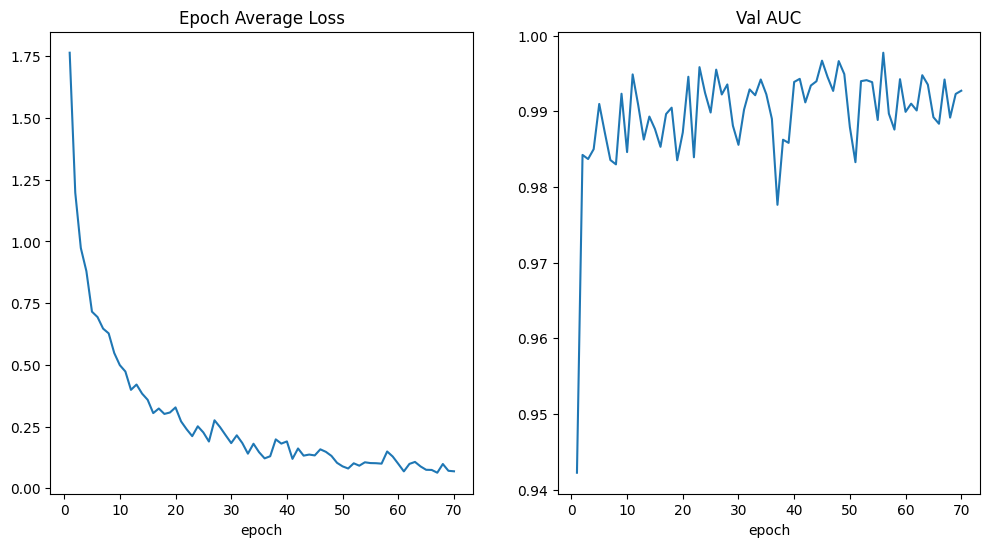

In [43]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [44]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [45]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.0833    0.0290    0.0430        69
           1     0.2973    0.3235    0.3099        68
           2     0.1333    0.1739    0.1509        69
           3     0.4857    0.2615    0.3400        65
           4     0.6250    0.0769    0.1370        65
           5     0.5204    0.7727    0.6220        66
           6     0.0000    0.0000    0.0000        28
           7     0.0000    0.0000    0.0000        21
           8     0.2581    0.3810    0.3077        21
           9     0.2246    0.6087    0.3281        69
          10     0.2449    0.1739    0.2034        69

    accuracy                         0.2803       610
   macro avg     0.2611    0.2547    0.2220       610
weighted avg     0.2943    0.2803    0.2453       610



In [46]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'coronal_full_unpretrained_seed{seed}.csv')

In [47]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.38 MB
Max VRAM used during training: 254.19 MB


## Training cycle for the sagittal part

## Pretrained

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70
epoch 1 average loss: 2.0029


Epochs:   1%|▏         | 1/70 [00:17<20:39, 17.97s/it]

1
saved new best metric model
current epoch: 1 current AUC: 0.9258 current accuracy: 0.5155 best AUC: 0.9258 at epoch: 1
----------
epoch 2/70
epoch 2 average loss: 1.3005


Epochs:   3%|▎         | 2/70 [00:35<20:08, 17.77s/it]

1
saved new best metric model
current epoch: 2 current AUC: 0.9583 current accuracy: 0.6708 best AUC: 0.9583 at epoch: 2
----------
epoch 3/70
epoch 3 average loss: 1.0172


Epochs:   4%|▍         | 3/70 [00:53<19:54, 17.83s/it]

1
saved new best metric model
current epoch: 3 current AUC: 0.9695 current accuracy: 0.7019 best AUC: 0.9695 at epoch: 3
----------
epoch 4/70
epoch 4 average loss: 0.8609


Epochs:   6%|▌         | 4/70 [01:11<19:35, 17.81s/it]

1
saved new best metric model
current epoch: 4 current AUC: 0.9805 current accuracy: 0.7640 best AUC: 0.9805 at epoch: 4
----------
epoch 5/70
epoch 5 average loss: 0.7528


Epochs:   7%|▋         | 5/70 [01:28<19:14, 17.76s/it]

1
saved new best metric model
current epoch: 5 current AUC: 0.9830 current accuracy: 0.8075 best AUC: 0.9830 at epoch: 5
----------
epoch 6/70
epoch 6 average loss: 0.6993


Epochs:   9%|▊         | 6/70 [01:46<18:53, 17.72s/it]

1
saved new best metric model
current epoch: 6 current AUC: 0.9898 current accuracy: 0.8261 best AUC: 0.9898 at epoch: 6
----------
epoch 7/70
epoch 7 average loss: 0.6153


Epochs:  10%|█         | 7/70 [02:04<18:34, 17.69s/it]

1
current epoch: 7 current AUC: 0.9800 current accuracy: 0.7578 best AUC: 0.9898 at epoch: 6
----------
epoch 8/70
epoch 8 average loss: 0.5760


Epochs:  11%|█▏        | 8/70 [02:21<18:12, 17.63s/it]

1
current epoch: 8 current AUC: 0.9882 current accuracy: 0.8509 best AUC: 0.9898 at epoch: 6
----------
epoch 9/70
epoch 9 average loss: 0.5791


Epochs:  13%|█▎        | 9/70 [02:39<17:57, 17.66s/it]

1
saved new best metric model
current epoch: 9 current AUC: 0.9957 current accuracy: 0.9068 best AUC: 0.9957 at epoch: 9
----------
epoch 10/70
epoch 10 average loss: 0.5170


Epochs:  14%|█▍        | 10/70 [02:57<17:41, 17.69s/it]

1
current epoch: 10 current AUC: 0.9813 current accuracy: 0.8075 best AUC: 0.9957 at epoch: 9
----------
epoch 11/70
epoch 11 average loss: 0.5003


Epochs:  16%|█▌        | 11/70 [03:14<17:20, 17.63s/it]

1
current epoch: 11 current AUC: 0.9918 current accuracy: 0.8323 best AUC: 0.9957 at epoch: 9
----------
epoch 12/70
epoch 12 average loss: 0.4401


Epochs:  17%|█▋        | 12/70 [03:32<17:04, 17.67s/it]

1
saved new best metric model
current epoch: 12 current AUC: 0.9974 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 12
----------
epoch 13/70
epoch 13 average loss: 0.4161


Epochs:  19%|█▊        | 13/70 [03:49<16:44, 17.63s/it]

1
current epoch: 13 current AUC: 0.9920 current accuracy: 0.8447 best AUC: 0.9974 at epoch: 12
----------
epoch 14/70
epoch 14 average loss: 0.4070


Epochs:  20%|██        | 14/70 [04:07<16:28, 17.65s/it]

1
current epoch: 14 current AUC: 0.9889 current accuracy: 0.8137 best AUC: 0.9974 at epoch: 12
----------
epoch 15/70
epoch 15 average loss: 0.3951


Epochs:  21%|██▏       | 15/70 [04:25<16:08, 17.61s/it]

1
current epoch: 15 current AUC: 0.9944 current accuracy: 0.9193 best AUC: 0.9974 at epoch: 12
----------
epoch 16/70
epoch 16 average loss: 0.3683


Epochs:  23%|██▎       | 16/70 [04:42<15:47, 17.55s/it]

1
current epoch: 16 current AUC: 0.9944 current accuracy: 0.9130 best AUC: 0.9974 at epoch: 12
----------
epoch 17/70
epoch 17 average loss: 0.3214


Epochs:  24%|██▍       | 17/70 [05:00<15:31, 17.58s/it]

1
saved new best metric model
current epoch: 17 current AUC: 0.9983 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 17
----------
epoch 18/70
epoch 18 average loss: 0.3376


Epochs:  26%|██▌       | 18/70 [05:17<15:16, 17.62s/it]

1
current epoch: 18 current AUC: 0.9842 current accuracy: 0.8634 best AUC: 0.9983 at epoch: 17
----------
epoch 19/70
epoch 19 average loss: 0.2907


Epochs:  27%|██▋       | 19/70 [05:35<14:59, 17.64s/it]

1
current epoch: 19 current AUC: 0.9933 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 17
----------
epoch 20/70
epoch 20 average loss: 0.2952


Epochs:  29%|██▊       | 20/70 [05:53<14:44, 17.70s/it]

1
current epoch: 20 current AUC: 0.9913 current accuracy: 0.8882 best AUC: 0.9983 at epoch: 17
----------
epoch 21/70
epoch 21 average loss: 0.2753


Epochs:  30%|███       | 21/70 [06:10<14:22, 17.60s/it]

1
current epoch: 21 current AUC: 0.9882 current accuracy: 0.8696 best AUC: 0.9983 at epoch: 17
----------
epoch 22/70
epoch 22 average loss: 0.2493


Epochs:  31%|███▏      | 22/70 [06:28<14:05, 17.61s/it]

1
current epoch: 22 current AUC: 0.9935 current accuracy: 0.9006 best AUC: 0.9983 at epoch: 17
----------
epoch 23/70
epoch 23 average loss: 0.2773


Epochs:  33%|███▎      | 23/70 [06:46<13:47, 17.60s/it]

1
current epoch: 23 current AUC: 0.9853 current accuracy: 0.8385 best AUC: 0.9983 at epoch: 17
----------
epoch 24/70
epoch 24 average loss: 0.2752


Epochs:  34%|███▍      | 24/70 [07:03<13:27, 17.55s/it]

1
current epoch: 24 current AUC: 0.9960 current accuracy: 0.9068 best AUC: 0.9983 at epoch: 17
----------
epoch 25/70
epoch 25 average loss: 0.2201


Epochs:  36%|███▌      | 25/70 [07:21<13:13, 17.63s/it]

1
saved new best metric model
current epoch: 25 current AUC: 0.9984 current accuracy: 0.9689 best AUC: 0.9984 at epoch: 25
----------
epoch 26/70
epoch 26 average loss: 0.2015


Epochs:  37%|███▋      | 26/70 [07:38<12:55, 17.63s/it]

1
current epoch: 26 current AUC: 0.9973 current accuracy: 0.9006 best AUC: 0.9984 at epoch: 25
----------
epoch 27/70
epoch 27 average loss: 0.2314


Epochs:  39%|███▊      | 27/70 [07:56<12:37, 17.62s/it]

1
current epoch: 27 current AUC: 0.9927 current accuracy: 0.8882 best AUC: 0.9984 at epoch: 25
----------
epoch 28/70
epoch 28 average loss: 0.2234


Epochs:  40%|████      | 28/70 [08:14<12:21, 17.66s/it]

1
current epoch: 28 current AUC: 0.9969 current accuracy: 0.9255 best AUC: 0.9984 at epoch: 25
----------
epoch 29/70
epoch 29 average loss: 0.2539


Epochs:  41%|████▏     | 29/70 [08:31<12:00, 17.58s/it]

1
current epoch: 29 current AUC: 0.9927 current accuracy: 0.8385 best AUC: 0.9984 at epoch: 25
----------
epoch 30/70
epoch 30 average loss: 0.2412


Epochs:  43%|████▎     | 30/70 [08:49<11:45, 17.63s/it]

1
current epoch: 30 current AUC: 0.9910 current accuracy: 0.8758 best AUC: 0.9984 at epoch: 25
----------
epoch 31/70
epoch 31 average loss: 0.2038


Epochs:  44%|████▍     | 31/70 [09:07<11:29, 17.68s/it]

1
current epoch: 31 current AUC: 0.9894 current accuracy: 0.8696 best AUC: 0.9984 at epoch: 25
----------
epoch 32/70
epoch 32 average loss: 0.1907


Epochs:  46%|████▌     | 32/70 [09:24<11:11, 17.68s/it]

1
current epoch: 32 current AUC: 0.9933 current accuracy: 0.8944 best AUC: 0.9984 at epoch: 25
----------
epoch 33/70
epoch 33 average loss: 0.2110


Epochs:  47%|████▋     | 33/70 [09:42<10:53, 17.67s/it]

1
current epoch: 33 current AUC: 0.9930 current accuracy: 0.8696 best AUC: 0.9984 at epoch: 25
----------
epoch 34/70
epoch 34 average loss: 0.1995


Epochs:  49%|████▊     | 34/70 [10:00<10:35, 17.65s/it]

1
saved new best metric model
current epoch: 34 current AUC: 0.9985 current accuracy: 0.9503 best AUC: 0.9985 at epoch: 34
----------
epoch 35/70
epoch 35 average loss: 0.1869


Epochs:  50%|█████     | 35/70 [10:17<10:14, 17.56s/it]

1
current epoch: 35 current AUC: 0.9981 current accuracy: 0.9255 best AUC: 0.9985 at epoch: 34
----------
epoch 36/70
epoch 36 average loss: 0.1767


Epochs:  51%|█████▏    | 36/70 [10:34<09:53, 17.46s/it]

1
current epoch: 36 current AUC: 0.9822 current accuracy: 0.8199 best AUC: 0.9985 at epoch: 34
----------
epoch 37/70
epoch 37 average loss: 0.1662


Epochs:  53%|█████▎    | 37/70 [10:52<09:36, 17.47s/it]

1
current epoch: 37 current AUC: 0.9918 current accuracy: 0.8758 best AUC: 0.9985 at epoch: 34
----------
epoch 38/70
epoch 38 average loss: 0.1750


Epochs:  54%|█████▍    | 38/70 [11:09<09:20, 17.50s/it]

1
current epoch: 38 current AUC: 0.9971 current accuracy: 0.9565 best AUC: 0.9985 at epoch: 34
----------
epoch 39/70
epoch 39 average loss: 0.1483


Epochs:  56%|█████▌    | 39/70 [11:27<09:02, 17.50s/it]

1
current epoch: 39 current AUC: 0.9879 current accuracy: 0.8571 best AUC: 0.9985 at epoch: 34
----------
epoch 40/70
epoch 40 average loss: 0.1478


Epochs:  57%|█████▋    | 40/70 [11:45<08:46, 17.57s/it]

1
current epoch: 40 current AUC: 0.9971 current accuracy: 0.9255 best AUC: 0.9985 at epoch: 34
----------
epoch 41/70
epoch 41 average loss: 0.1684


Epochs:  59%|█████▊    | 41/70 [12:02<08:27, 17.51s/it]

1
current epoch: 41 current AUC: 0.9977 current accuracy: 0.9255 best AUC: 0.9985 at epoch: 34
----------
epoch 42/70
epoch 42 average loss: 0.1382


Epochs:  60%|██████    | 42/70 [12:20<08:11, 17.55s/it]

1
current epoch: 42 current AUC: 0.9961 current accuracy: 0.9255 best AUC: 0.9985 at epoch: 34
----------
epoch 43/70
epoch 43 average loss: 0.1056


Epochs:  61%|██████▏   | 43/70 [12:37<07:51, 17.46s/it]

1
current epoch: 43 current AUC: 0.9974 current accuracy: 0.9193 best AUC: 0.9985 at epoch: 34
----------
epoch 44/70
epoch 44 average loss: 0.1655


Epochs:  63%|██████▎   | 44/70 [12:54<07:33, 17.46s/it]

1
current epoch: 44 current AUC: 0.9952 current accuracy: 0.8944 best AUC: 0.9985 at epoch: 34
----------
epoch 45/70
epoch 45 average loss: 0.1659


Epochs:  64%|██████▍   | 45/70 [13:12<07:16, 17.46s/it]

1
current epoch: 45 current AUC: 0.9944 current accuracy: 0.8944 best AUC: 0.9985 at epoch: 34
----------
epoch 46/70
epoch 46 average loss: 0.1763


Epochs:  66%|██████▌   | 46/70 [13:29<06:58, 17.43s/it]

1
current epoch: 46 current AUC: 0.9910 current accuracy: 0.8758 best AUC: 0.9985 at epoch: 34
----------
epoch 47/70
epoch 47 average loss: 0.1247


Epochs:  67%|██████▋   | 47/70 [13:46<06:40, 17.42s/it]

1
current epoch: 47 current AUC: 0.9912 current accuracy: 0.8820 best AUC: 0.9985 at epoch: 34
----------
epoch 48/70
epoch 48 average loss: 0.1257


Epochs:  69%|██████▊   | 48/70 [14:04<06:24, 17.46s/it]

1
current epoch: 48 current AUC: 0.9896 current accuracy: 0.8758 best AUC: 0.9985 at epoch: 34
----------
epoch 49/70
epoch 49 average loss: 0.1506


Epochs:  70%|███████   | 49/70 [14:21<06:05, 17.42s/it]

1
current epoch: 49 current AUC: 0.9950 current accuracy: 0.8944 best AUC: 0.9985 at epoch: 34
----------
epoch 50/70
epoch 50 average loss: 0.1552


Epochs:  71%|███████▏  | 50/70 [14:39<05:47, 17.40s/it]

1
current epoch: 50 current AUC: 0.9930 current accuracy: 0.8820 best AUC: 0.9985 at epoch: 34
----------
epoch 51/70
epoch 51 average loss: 0.1529


Epochs:  73%|███████▎  | 51/70 [14:56<05:30, 17.40s/it]

1
current epoch: 51 current AUC: 0.9977 current accuracy: 0.9317 best AUC: 0.9985 at epoch: 34
----------
epoch 52/70
epoch 52 average loss: 0.1400


Epochs:  74%|███████▍  | 52/70 [15:14<05:14, 17.50s/it]

1
current epoch: 52 current AUC: 0.9824 current accuracy: 0.8137 best AUC: 0.9985 at epoch: 34
----------
epoch 53/70
epoch 53 average loss: 0.1364


Epochs:  76%|███████▌  | 53/70 [15:31<04:57, 17.49s/it]

1
current epoch: 53 current AUC: 0.9947 current accuracy: 0.9006 best AUC: 0.9985 at epoch: 34
----------
epoch 54/70
epoch 54 average loss: 0.1117


Epochs:  77%|███████▋  | 54/70 [15:49<04:39, 17.46s/it]

1
current epoch: 54 current AUC: 0.9961 current accuracy: 0.9130 best AUC: 0.9985 at epoch: 34
----------
epoch 55/70
epoch 55 average loss: 0.0946


Epochs:  79%|███████▊  | 55/70 [16:06<04:21, 17.46s/it]

1
current epoch: 55 current AUC: 0.9949 current accuracy: 0.8944 best AUC: 0.9985 at epoch: 34
----------
epoch 56/70
epoch 56 average loss: 0.1005


Epochs:  80%|████████  | 56/70 [16:24<04:04, 17.49s/it]

1
current epoch: 56 current AUC: 0.9862 current accuracy: 0.8571 best AUC: 0.9985 at epoch: 34
----------
epoch 57/70
epoch 57 average loss: 0.1132


Epochs:  81%|████████▏ | 57/70 [16:41<03:46, 17.42s/it]

1
current epoch: 57 current AUC: 0.9873 current accuracy: 0.8571 best AUC: 0.9985 at epoch: 34
----------
epoch 58/70
epoch 58 average loss: 0.0963


Epochs:  83%|████████▎ | 58/70 [16:58<03:29, 17.45s/it]

1
current epoch: 58 current AUC: 0.9888 current accuracy: 0.8758 best AUC: 0.9985 at epoch: 34
----------
epoch 59/70
epoch 59 average loss: 0.1037


Epochs:  84%|████████▍ | 59/70 [17:16<03:11, 17.45s/it]

1
current epoch: 59 current AUC: 0.9861 current accuracy: 0.8571 best AUC: 0.9985 at epoch: 34
----------
epoch 60/70
epoch 60 average loss: 0.0826


Epochs:  86%|████████▌ | 60/70 [17:33<02:54, 17.48s/it]

1
current epoch: 60 current AUC: 0.9956 current accuracy: 0.9006 best AUC: 0.9985 at epoch: 34
----------
epoch 61/70
epoch 61 average loss: 0.0666


Epochs:  87%|████████▋ | 61/70 [17:51<02:37, 17.49s/it]

1
current epoch: 61 current AUC: 0.9902 current accuracy: 0.8571 best AUC: 0.9985 at epoch: 34
----------
epoch 62/70
epoch 62 average loss: 0.0953


Epochs:  89%|████████▊ | 62/70 [18:08<02:19, 17.48s/it]

1
current epoch: 62 current AUC: 0.9954 current accuracy: 0.9193 best AUC: 0.9985 at epoch: 34
----------
epoch 63/70
epoch 63 average loss: 0.1163


Epochs:  90%|█████████ | 63/70 [18:26<02:03, 17.57s/it]

1
current epoch: 63 current AUC: 0.9862 current accuracy: 0.8634 best AUC: 0.9985 at epoch: 34
----------
epoch 64/70
epoch 64 average loss: 0.0955


Epochs:  91%|█████████▏| 64/70 [18:44<01:45, 17.58s/it]

1
current epoch: 64 current AUC: 0.9961 current accuracy: 0.9130 best AUC: 0.9985 at epoch: 34
----------
epoch 65/70
epoch 65 average loss: 0.1310


Epochs:  93%|█████████▎| 65/70 [19:01<01:27, 17.57s/it]

1
current epoch: 65 current AUC: 0.9969 current accuracy: 0.9379 best AUC: 0.9985 at epoch: 34
----------
epoch 66/70
epoch 66 average loss: 0.1152


Epochs:  94%|█████████▍| 66/70 [19:19<01:10, 17.59s/it]

1
current epoch: 66 current AUC: 0.9962 current accuracy: 0.9317 best AUC: 0.9985 at epoch: 34
----------
epoch 67/70
epoch 67 average loss: 0.0930


Epochs:  96%|█████████▌| 67/70 [19:36<00:52, 17.55s/it]

1
current epoch: 67 current AUC: 0.9946 current accuracy: 0.9068 best AUC: 0.9985 at epoch: 34
----------
epoch 68/70
epoch 68 average loss: 0.0899


Epochs:  97%|█████████▋| 68/70 [19:54<00:34, 17.47s/it]

1
current epoch: 68 current AUC: 0.9964 current accuracy: 0.9379 best AUC: 0.9985 at epoch: 34
----------
epoch 69/70
epoch 69 average loss: 0.0918
1


Epochs:  99%|█████████▊| 69/70 [20:11<00:17, 17.48s/it]

saved new best metric model
current epoch: 69 current AUC: 0.9989 current accuracy: 0.9627 best AUC: 0.9989 at epoch: 69
----------
epoch 70/70
epoch 70 average loss: 0.0905


Epochs: 100%|██████████| 70/70 [20:29<00:00, 17.56s/it]

1
current epoch: 70 current AUC: 0.9825 current accuracy: 0.8447 best AUC: 0.9989 at epoch: 69
train completed, best_metric: 0.9989 at epoch: 69


In [50]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1229.34 seconds
CPU time used: 14736.12 seconds
Memory used: 295.50 MB
GPU Memory Used: 193.88 MB
Max GPU Memory Used: 238.14 MB


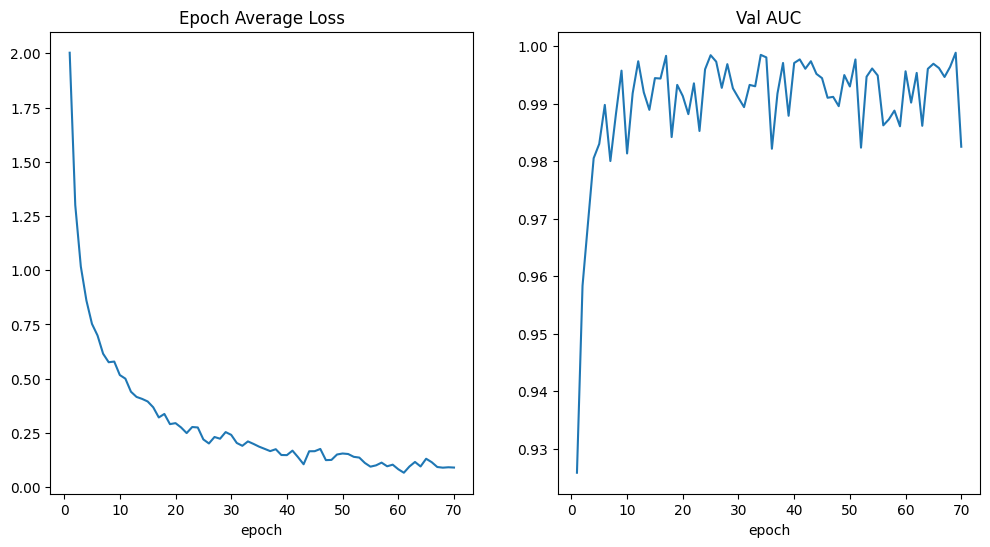

In [51]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [52]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [53]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9855    0.9927        69
           1     0.5974    0.6765    0.6345        68
           2     0.6182    0.4928    0.5484        69
           3     0.5476    0.7077    0.6174        65
           4     0.6032    0.5846    0.5938        65
           5     0.8788    0.8788    0.8788        66
           6     1.0000    0.8929    0.9434        28
           7     0.9130    1.0000    0.9545        21
           8     1.0000    0.9524    0.9756        21
           9     0.9524    0.8696    0.9091        69
          10     0.9242    0.8841    0.9037        69

    accuracy                         0.7820       610
   macro avg     0.8213    0.8113    0.8138       610
weighted avg     0.7914    0.7820    0.7840       610



In [54]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'sagittal_full_pretrained_seed{seed}.csv')

In [55]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 193.87 MB
Max VRAM used during training: 238.19 MB


## Unpretrained

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1
auc_metric = ROCAUCMetric()

In [57]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70
epoch 1 average loss: 1.8634


Epochs:   1%|▏         | 1/70 [00:17<20:25, 17.76s/it]

1
saved new best metric model
current epoch: 1 current AUC: 0.9599 current accuracy: 0.6398 best AUC: 0.9599 at epoch: 1
----------
epoch 2/70
epoch 2 average loss: 1.3228


Epochs:   3%|▎         | 2/70 [00:35<20:23, 17.99s/it]

1
saved new best metric model
current epoch: 2 current AUC: 0.9740 current accuracy: 0.6957 best AUC: 0.9740 at epoch: 2
----------
epoch 3/70
epoch 3 average loss: 1.0263


Epochs:   4%|▍         | 3/70 [00:53<19:58, 17.89s/it]

1
saved new best metric model
current epoch: 3 current AUC: 0.9826 current accuracy: 0.6894 best AUC: 0.9826 at epoch: 3
----------
epoch 4/70
epoch 4 average loss: 0.9378


Epochs:   6%|▌         | 4/70 [01:11<19:33, 17.77s/it]

1
saved new best metric model
current epoch: 4 current AUC: 0.9829 current accuracy: 0.7081 best AUC: 0.9829 at epoch: 4
----------
epoch 5/70
epoch 5 average loss: 0.8432


Epochs:   7%|▋         | 5/70 [01:29<19:14, 17.76s/it]

1
saved new best metric model
current epoch: 5 current AUC: 0.9896 current accuracy: 0.7950 best AUC: 0.9896 at epoch: 5
----------
epoch 6/70
epoch 6 average loss: 0.7551


Epochs:   9%|▊         | 6/70 [01:46<18:55, 17.75s/it]

1
current epoch: 6 current AUC: 0.9880 current accuracy: 0.7826 best AUC: 0.9896 at epoch: 5
----------
epoch 7/70
epoch 7 average loss: 0.7342


Epochs:  10%|█         | 7/70 [02:04<18:39, 17.76s/it]

1
current epoch: 7 current AUC: 0.9866 current accuracy: 0.8012 best AUC: 0.9896 at epoch: 5
----------
epoch 8/70
epoch 8 average loss: 0.6447


Epochs:  11%|█▏        | 8/70 [02:22<18:21, 17.77s/it]

1
current epoch: 8 current AUC: 0.9804 current accuracy: 0.7764 best AUC: 0.9896 at epoch: 5
----------
epoch 9/70
epoch 9 average loss: 0.5931


Epochs:  13%|█▎        | 9/70 [02:39<17:56, 17.64s/it]

1
current epoch: 9 current AUC: 0.9818 current accuracy: 0.7640 best AUC: 0.9896 at epoch: 5
----------
epoch 10/70
epoch 10 average loss: 0.5282


Epochs:  14%|█▍        | 10/70 [02:57<17:40, 17.67s/it]

1
saved new best metric model
current epoch: 10 current AUC: 0.9913 current accuracy: 0.8447 best AUC: 0.9913 at epoch: 10
----------
epoch 11/70
epoch 11 average loss: 0.5330


Epochs:  16%|█▌        | 11/70 [03:14<17:21, 17.65s/it]

1
current epoch: 11 current AUC: 0.9867 current accuracy: 0.8075 best AUC: 0.9913 at epoch: 10
----------
epoch 12/70
epoch 12 average loss: 0.5030


Epochs:  17%|█▋        | 12/70 [03:32<17:01, 17.62s/it]

1
current epoch: 12 current AUC: 0.9902 current accuracy: 0.8261 best AUC: 0.9913 at epoch: 10
----------
epoch 13/70
epoch 13 average loss: 0.4258


Epochs:  19%|█▊        | 13/70 [03:50<16:43, 17.61s/it]

1
current epoch: 13 current AUC: 0.9890 current accuracy: 0.8447 best AUC: 0.9913 at epoch: 10
----------
epoch 14/70
epoch 14 average loss: 0.3816


Epochs:  20%|██        | 14/70 [04:07<16:27, 17.63s/it]

1
current epoch: 14 current AUC: 0.9909 current accuracy: 0.8447 best AUC: 0.9913 at epoch: 10
----------
epoch 15/70
epoch 15 average loss: 0.3808


Epochs:  21%|██▏       | 15/70 [04:25<16:08, 17.61s/it]

1
current epoch: 15 current AUC: 0.9846 current accuracy: 0.8199 best AUC: 0.9913 at epoch: 10
----------
epoch 16/70
epoch 16 average loss: 0.3872


Epochs:  23%|██▎       | 16/70 [04:43<15:53, 17.66s/it]

1
saved new best metric model
current epoch: 16 current AUC: 0.9942 current accuracy: 0.8571 best AUC: 0.9942 at epoch: 16
----------
epoch 17/70
epoch 17 average loss: 0.3617


Epochs:  24%|██▍       | 17/70 [05:00<15:35, 17.64s/it]

1
saved new best metric model
current epoch: 17 current AUC: 0.9946 current accuracy: 0.8261 best AUC: 0.9946 at epoch: 17
----------
epoch 18/70
epoch 18 average loss: 0.3097


Epochs:  26%|██▌       | 18/70 [05:18<15:16, 17.62s/it]

1
current epoch: 18 current AUC: 0.9830 current accuracy: 0.8509 best AUC: 0.9946 at epoch: 17
----------
epoch 19/70
epoch 19 average loss: 0.3812


Epochs:  27%|██▋       | 19/70 [05:35<14:58, 17.62s/it]

1
current epoch: 19 current AUC: 0.9892 current accuracy: 0.8758 best AUC: 0.9946 at epoch: 17
----------
epoch 20/70
epoch 20 average loss: 0.3254


Epochs:  29%|██▊       | 20/70 [05:53<14:41, 17.62s/it]

1
current epoch: 20 current AUC: 0.9805 current accuracy: 0.8012 best AUC: 0.9946 at epoch: 17
----------
epoch 21/70
epoch 21 average loss: 0.2631


Epochs:  30%|███       | 21/70 [06:11<14:24, 17.65s/it]

1
current epoch: 21 current AUC: 0.9807 current accuracy: 0.7702 best AUC: 0.9946 at epoch: 17
----------
epoch 22/70
epoch 22 average loss: 0.2479


Epochs:  31%|███▏      | 22/70 [06:29<14:09, 17.69s/it]

1
current epoch: 22 current AUC: 0.9856 current accuracy: 0.8261 best AUC: 0.9946 at epoch: 17
----------
epoch 23/70
epoch 23 average loss: 0.2417


Epochs:  33%|███▎      | 23/70 [06:46<13:51, 17.70s/it]

1
current epoch: 23 current AUC: 0.9843 current accuracy: 0.8137 best AUC: 0.9946 at epoch: 17
----------
epoch 24/70
epoch 24 average loss: 0.2210


Epochs:  34%|███▍      | 24/70 [07:04<13:33, 17.68s/it]

1
current epoch: 24 current AUC: 0.9935 current accuracy: 0.8447 best AUC: 0.9946 at epoch: 17
----------
epoch 25/70
epoch 25 average loss: 0.2484


Epochs:  36%|███▌      | 25/70 [07:22<13:14, 17.66s/it]

1
current epoch: 25 current AUC: 0.9931 current accuracy: 0.8447 best AUC: 0.9946 at epoch: 17
----------
epoch 26/70
epoch 26 average loss: 0.2281


Epochs:  37%|███▋      | 26/70 [07:39<12:54, 17.61s/it]

1
current epoch: 26 current AUC: 0.9872 current accuracy: 0.8261 best AUC: 0.9946 at epoch: 17
----------
epoch 27/70
epoch 27 average loss: 0.2532


Epochs:  39%|███▊      | 27/70 [07:57<12:37, 17.62s/it]

1
current epoch: 27 current AUC: 0.9842 current accuracy: 0.8012 best AUC: 0.9946 at epoch: 17
----------
epoch 28/70
epoch 28 average loss: 0.2170


Epochs:  40%|████      | 28/70 [08:14<12:19, 17.60s/it]

1
current epoch: 28 current AUC: 0.9871 current accuracy: 0.8634 best AUC: 0.9946 at epoch: 17
----------
epoch 29/70
epoch 29 average loss: 0.2200


Epochs:  41%|████▏     | 29/70 [08:32<12:00, 17.59s/it]

1
current epoch: 29 current AUC: 0.9924 current accuracy: 0.9068 best AUC: 0.9946 at epoch: 17
----------
epoch 30/70
epoch 30 average loss: 0.2178


Epochs:  43%|████▎     | 30/70 [08:49<11:44, 17.61s/it]

1
current epoch: 30 current AUC: 0.9824 current accuracy: 0.8075 best AUC: 0.9946 at epoch: 17
----------
epoch 31/70
epoch 31 average loss: 0.2183


Epochs:  44%|████▍     | 31/70 [09:07<11:28, 17.66s/it]

1
current epoch: 31 current AUC: 0.9920 current accuracy: 0.8696 best AUC: 0.9946 at epoch: 17
----------
epoch 32/70
epoch 32 average loss: 0.1934


Epochs:  46%|████▌     | 32/70 [09:25<11:10, 17.64s/it]

1
current epoch: 32 current AUC: 0.9866 current accuracy: 0.8571 best AUC: 0.9946 at epoch: 17
----------
epoch 33/70
epoch 33 average loss: 0.1818


Epochs:  47%|████▋     | 33/70 [09:43<10:55, 17.72s/it]

1
current epoch: 33 current AUC: 0.9934 current accuracy: 0.8820 best AUC: 0.9946 at epoch: 17
----------
epoch 34/70
epoch 34 average loss: 0.1279


Epochs:  49%|████▊     | 34/70 [10:01<10:39, 17.77s/it]

1
current epoch: 34 current AUC: 0.9916 current accuracy: 0.8944 best AUC: 0.9946 at epoch: 17
----------
epoch 35/70
epoch 35 average loss: 0.1802


Epochs:  50%|█████     | 35/70 [10:18<10:22, 17.78s/it]

1
current epoch: 35 current AUC: 0.9892 current accuracy: 0.8634 best AUC: 0.9946 at epoch: 17
----------
epoch 36/70
epoch 36 average loss: 0.1437


Epochs:  51%|█████▏    | 36/70 [10:36<10:03, 17.75s/it]

1
saved new best metric model
current epoch: 36 current AUC: 0.9954 current accuracy: 0.9006 best AUC: 0.9954 at epoch: 36
----------
epoch 37/70
epoch 37 average loss: 0.1874


Epochs:  53%|█████▎    | 37/70 [10:54<09:42, 17.67s/it]

1
current epoch: 37 current AUC: 0.9929 current accuracy: 0.9130 best AUC: 0.9954 at epoch: 36
----------
epoch 38/70
epoch 38 average loss: 0.1584


Epochs:  54%|█████▍    | 38/70 [11:11<09:26, 17.70s/it]

1
current epoch: 38 current AUC: 0.9952 current accuracy: 0.9193 best AUC: 0.9954 at epoch: 36
----------
epoch 39/70
epoch 39 average loss: 0.1578


Epochs:  56%|█████▌    | 39/70 [11:29<09:10, 17.75s/it]

1
current epoch: 39 current AUC: 0.9887 current accuracy: 0.8385 best AUC: 0.9954 at epoch: 36
----------
epoch 40/70
epoch 40 average loss: 0.1551


Epochs:  57%|█████▋    | 40/70 [11:47<08:53, 17.78s/it]

1
current epoch: 40 current AUC: 0.9911 current accuracy: 0.8758 best AUC: 0.9954 at epoch: 36
----------
epoch 41/70
epoch 41 average loss: 0.1491


Epochs:  59%|█████▊    | 41/70 [12:05<08:34, 17.75s/it]

1
current epoch: 41 current AUC: 0.9878 current accuracy: 0.8758 best AUC: 0.9954 at epoch: 36
----------
epoch 42/70
epoch 42 average loss: 0.1394


Epochs:  60%|██████    | 42/70 [12:22<08:15, 17.70s/it]

1
current epoch: 42 current AUC: 0.9872 current accuracy: 0.8447 best AUC: 0.9954 at epoch: 36
----------
epoch 43/70
epoch 43 average loss: 0.1346


Epochs:  61%|██████▏   | 43/70 [12:40<07:56, 17.65s/it]

1
current epoch: 43 current AUC: 0.9891 current accuracy: 0.8261 best AUC: 0.9954 at epoch: 36
----------
epoch 44/70
epoch 44 average loss: 0.1503


Epochs:  63%|██████▎   | 44/70 [12:57<07:36, 17.57s/it]

1
current epoch: 44 current AUC: 0.9916 current accuracy: 0.8509 best AUC: 0.9954 at epoch: 36
----------
epoch 45/70
epoch 45 average loss: 0.1157


Epochs:  64%|██████▍   | 45/70 [13:15<07:18, 17.55s/it]

1
current epoch: 45 current AUC: 0.9894 current accuracy: 0.8634 best AUC: 0.9954 at epoch: 36
----------
epoch 46/70
epoch 46 average loss: 0.1454


Epochs:  66%|██████▌   | 46/70 [13:33<07:02, 17.62s/it]

1
current epoch: 46 current AUC: 0.9900 current accuracy: 0.8634 best AUC: 0.9954 at epoch: 36
----------
epoch 47/70
epoch 47 average loss: 0.1209


Epochs:  67%|██████▋   | 47/70 [13:50<06:46, 17.68s/it]

1
current epoch: 47 current AUC: 0.9929 current accuracy: 0.8571 best AUC: 0.9954 at epoch: 36
----------
epoch 48/70
epoch 48 average loss: 0.1011


Epochs:  69%|██████▊   | 48/70 [14:08<06:29, 17.71s/it]

1
current epoch: 48 current AUC: 0.9936 current accuracy: 0.9006 best AUC: 0.9954 at epoch: 36
----------
epoch 49/70
epoch 49 average loss: 0.0939


Epochs:  70%|███████   | 49/70 [14:26<06:14, 17.82s/it]

1
saved new best metric model
current epoch: 49 current AUC: 0.9955 current accuracy: 0.9068 best AUC: 0.9955 at epoch: 49
----------
epoch 50/70
epoch 50 average loss: 0.1326


Epochs:  71%|███████▏  | 50/70 [14:44<05:57, 17.89s/it]

1
saved new best metric model
current epoch: 50 current AUC: 0.9979 current accuracy: 0.9317 best AUC: 0.9979 at epoch: 50
----------
epoch 51/70
epoch 51 average loss: 0.1397


Epochs:  73%|███████▎  | 51/70 [15:02<05:39, 17.89s/it]

1
current epoch: 51 current AUC: 0.9912 current accuracy: 0.8199 best AUC: 0.9979 at epoch: 50
----------
epoch 52/70
epoch 52 average loss: 0.1239


Epochs:  74%|███████▍  | 52/70 [15:20<05:22, 17.89s/it]

1
current epoch: 52 current AUC: 0.9943 current accuracy: 0.9130 best AUC: 0.9979 at epoch: 50
----------
epoch 53/70
epoch 53 average loss: 0.1194


Epochs:  76%|███████▌  | 53/70 [15:38<05:04, 17.91s/it]

1
current epoch: 53 current AUC: 0.9862 current accuracy: 0.8571 best AUC: 0.9979 at epoch: 50
----------
epoch 54/70
epoch 54 average loss: 0.1107


Epochs:  77%|███████▋  | 54/70 [15:56<04:47, 17.94s/it]

1
current epoch: 54 current AUC: 0.9923 current accuracy: 0.8447 best AUC: 0.9979 at epoch: 50
----------
epoch 55/70
epoch 55 average loss: 0.0809


Epochs:  79%|███████▊  | 55/70 [16:14<04:30, 18.00s/it]

1
current epoch: 55 current AUC: 0.9914 current accuracy: 0.9006 best AUC: 0.9979 at epoch: 50
----------
epoch 56/70
epoch 56 average loss: 0.0980


Epochs:  80%|████████  | 56/70 [16:32<04:11, 17.94s/it]

1
current epoch: 56 current AUC: 0.9965 current accuracy: 0.8820 best AUC: 0.9979 at epoch: 50
----------
epoch 57/70
epoch 57 average loss: 0.0828


Epochs:  81%|████████▏ | 57/70 [16:50<03:53, 17.93s/it]

1
current epoch: 57 current AUC: 0.9971 current accuracy: 0.9255 best AUC: 0.9979 at epoch: 50
----------
epoch 58/70
epoch 58 average loss: 0.1025


Epochs:  83%|████████▎ | 58/70 [17:08<03:34, 17.88s/it]

1
current epoch: 58 current AUC: 0.9945 current accuracy: 0.9130 best AUC: 0.9979 at epoch: 50
----------
epoch 59/70
epoch 59 average loss: 0.0821


Epochs:  84%|████████▍ | 59/70 [17:25<03:15, 17.80s/it]

1
current epoch: 59 current AUC: 0.9898 current accuracy: 0.8696 best AUC: 0.9979 at epoch: 50
----------
epoch 60/70
epoch 60 average loss: 0.1024


Epochs:  86%|████████▌ | 60/70 [17:43<02:58, 17.88s/it]

1
current epoch: 60 current AUC: 0.9936 current accuracy: 0.8882 best AUC: 0.9979 at epoch: 50
----------
epoch 61/70
epoch 61 average loss: 0.1032


Epochs:  87%|████████▋ | 61/70 [18:01<02:40, 17.85s/it]

1
current epoch: 61 current AUC: 0.9946 current accuracy: 0.8944 best AUC: 0.9979 at epoch: 50
----------
epoch 62/70
epoch 62 average loss: 0.1303


Epochs:  89%|████████▊ | 62/70 [18:19<02:23, 17.88s/it]

1
current epoch: 62 current AUC: 0.9929 current accuracy: 0.8882 best AUC: 0.9979 at epoch: 50
----------
epoch 63/70
epoch 63 average loss: 0.1364


Epochs:  90%|█████████ | 63/70 [18:37<02:04, 17.85s/it]

1
current epoch: 63 current AUC: 0.9944 current accuracy: 0.9068 best AUC: 0.9979 at epoch: 50
----------
epoch 64/70
epoch 64 average loss: 0.1320


Epochs:  91%|█████████▏| 64/70 [18:54<01:46, 17.76s/it]

1
current epoch: 64 current AUC: 0.9918 current accuracy: 0.8696 best AUC: 0.9979 at epoch: 50
----------
epoch 65/70
epoch 65 average loss: 0.0912


Epochs:  93%|█████████▎| 65/70 [19:12<01:28, 17.79s/it]

1
current epoch: 65 current AUC: 0.9844 current accuracy: 0.8323 best AUC: 0.9979 at epoch: 50
----------
epoch 66/70
epoch 66 average loss: 0.0748


Epochs:  94%|█████████▍| 66/70 [19:30<01:11, 17.79s/it]

1
current epoch: 66 current AUC: 0.9924 current accuracy: 0.8882 best AUC: 0.9979 at epoch: 50
----------
epoch 67/70
epoch 67 average loss: 0.0826


Epochs:  96%|█████████▌| 67/70 [19:48<00:53, 17.85s/it]

1
current epoch: 67 current AUC: 0.9960 current accuracy: 0.8758 best AUC: 0.9979 at epoch: 50
----------
epoch 68/70
epoch 68 average loss: 0.1073


Epochs:  97%|█████████▋| 68/70 [20:06<00:35, 17.87s/it]

1
current epoch: 68 current AUC: 0.9976 current accuracy: 0.9130 best AUC: 0.9979 at epoch: 50
----------
epoch 69/70
epoch 69 average loss: 0.0942


Epochs:  99%|█████████▊| 69/70 [20:24<00:17, 17.82s/it]

1
current epoch: 69 current AUC: 0.9933 current accuracy: 0.9130 best AUC: 0.9979 at epoch: 50
----------
epoch 70/70
epoch 70 average loss: 0.0749


Epochs: 100%|██████████| 70/70 [20:42<00:00, 17.74s/it]

1
current epoch: 70 current AUC: 0.9925 current accuracy: 0.8820 best AUC: 0.9979 at epoch: 50
train completed, best_metric: 0.9979 at epoch: 50


In [58]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")

Training time: 1242.14 seconds
CPU time used: 14889.73 seconds
Memory used: 342.98 MB
GPU Memory Used: 194.77 MB
Max GPU Memory Used: 254.06 MB


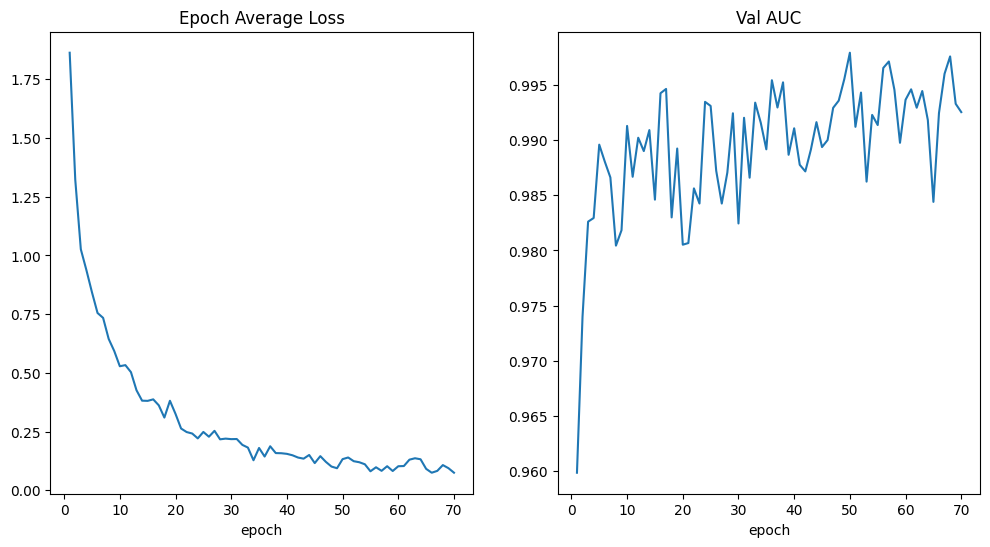

In [59]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [60]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [61]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.7910    0.7681    0.7794        69
           1     0.6250    0.5147    0.5645        68
           2     0.4762    0.2899    0.3604        69
           3     0.4267    0.4923    0.4571        65
           4     0.4737    0.1385    0.2143        65
           5     0.4952    0.7879    0.6082        66
           6     0.4000    0.2857    0.3333        28
           7     1.0000    0.4286    0.6000        21
           8     0.5152    0.8095    0.6296        21
           9     0.4906    0.7536    0.5943        69
          10     0.3974    0.4493    0.4218        69

    accuracy                         0.5213       610
   macro avg     0.5537    0.5198    0.5057       610
weighted avg     0.5335    0.5213    0.5018       610



In [62]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'sagittal_full_unpretrained_seed{seed}.csv')

In [63]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 194.76 MB
Max VRAM used during training: 254.06 MB


# Using 2d models as a backbone

In [64]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [65]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [69]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.2177015235347133
Epoch 2, Loss: 1.8034286537478048
Epoch 3, Loss: 1.5095447109591575
Epoch 4, Loss: 1.2807602267111502
Epoch 5, Loss: 1.0994646760725206
Epoch 6, Loss: 0.9786630272865295
Epoch 7, Loss: 0.88050780757781
Epoch 8, Loss: 0.8063209537536867
Epoch 9, Loss: 0.744332694238232
Epoch 10, Loss: 0.6829472030362775
Epoch 11, Loss: 0.6475993664033951
Epoch 12, Loss: 0.6145795939430114
Epoch 13, Loss: 0.5793929667242111
Epoch 14, Loss: 0.5568083399726499
Epoch 15, Loss: 0.5235182114185826
Epoch 16, Loss: 0.5072562699356387
Epoch 17, Loss: 0.4704330352044875
Epoch 18, Loss: 0.46942556000524954
Epoch 19, Loss: 0.44369082393184783
Epoch 20, Loss: 0.435280627781345
Epoch 21, Loss: 0.42569282554811044
Epoch 22, Loss: 0.4175638407468796
Epoch 23, Loss: 0.3931705403712488
Epoch 24, Loss: 0.3991776502901508
Epoch 25, Loss: 0.38581391015360433
Epoch 26, Loss: 0.3859937729374055
Epoch 27, Loss: 0.38052046587390287
Epoch 28, Loss: 0.35861127655352315
Epoch 29, Loss: 0.363463684

In [70]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 58.09 seconds
CPU time used: 695.39 seconds
Memory used: 54.76 MB
GPU Memory Used: 395.29 MB
Max GPU Memory Used: 1204.35 MB


In [71]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 395.29 MB
Max VRAM used during training: 1204.35 MB


In [72]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [73]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9866


In [74]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.7571    0.7794    0.7681        68
           2     0.7429    0.7536    0.7482        69
           3     0.8333    0.8462    0.8397        65
           4     0.8644    0.7846    0.8226        65
           5     0.8406    0.8788    0.8593        66
           6     1.0000    0.7857    0.8800        28
           7     1.0000    0.9524    0.9756        21
           8     0.9545    1.0000    0.9767        21
           9     0.8108    0.8696    0.8392        69
          10     0.9254    0.8986    0.9118        69

    accuracy                         0.8574       610
   macro avg     0.8819    0.8681    0.8733       610
weighted avg     0.8598    0.8574    0.8575       610



In [75]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'combined_unpretrained_full_seed{seed}.csv')

In [76]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 395.91 MB
Max VRAM used during training: 1204.35 MB


### Pretrained

In [77]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [78]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [79]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [80]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:45,  1.56s/it]

Epoch 1, Loss: 2.3713439126168527


Epochs:   7%|▋         | 2/30 [00:02<00:41,  1.47s/it]

Epoch 2, Loss: 1.7829186493350613


Epochs:  10%|█         | 3/30 [00:04<00:38,  1.44s/it]

Epoch 3, Loss: 1.381268278245003


Epochs:  13%|█▎        | 4/30 [00:05<00:37,  1.42s/it]

Epoch 4, Loss: 1.1210281329770242


Epochs:  17%|█▋        | 5/30 [00:07<00:35,  1.42s/it]

Epoch 5, Loss: 0.9504111505323841


Epochs:  20%|██        | 6/30 [00:08<00:33,  1.41s/it]

Epoch 6, Loss: 0.8152235727156362


Epochs:  23%|██▎       | 7/30 [00:09<00:32,  1.41s/it]

Epoch 7, Loss: 0.7342991578963495


Epochs:  27%|██▋       | 8/30 [00:11<00:31,  1.41s/it]

Epoch 8, Loss: 0.6780769353912722


Epochs:  30%|███       | 9/30 [00:12<00:29,  1.41s/it]

Epoch 9, Loss: 0.6287889884364221


Epochs:  33%|███▎      | 10/30 [00:14<00:28,  1.41s/it]

Epoch 10, Loss: 0.5777039950893771


Epochs:  37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

Epoch 11, Loss: 0.5467313864538746


Epochs:  40%|████      | 12/30 [00:17<00:25,  1.40s/it]

Epoch 12, Loss: 0.5040963753577201


Epochs:  43%|████▎     | 13/30 [00:18<00:23,  1.40s/it]

Epoch 13, Loss: 0.47022305861596136


Epochs:  47%|████▋     | 14/30 [00:19<00:22,  1.41s/it]

Epoch 14, Loss: 0.4659493363672687


Epochs:  50%|█████     | 15/30 [00:21<00:21,  1.41s/it]

Epoch 15, Loss: 0.4452233679832951


Epochs:  53%|█████▎    | 16/30 [00:22<00:19,  1.41s/it]

Epoch 16, Loss: 0.41969165975047695


Epochs:  57%|█████▋    | 17/30 [00:24<00:18,  1.41s/it]

Epoch 17, Loss: 0.402116205423109


Epochs:  60%|██████    | 18/30 [00:25<00:16,  1.41s/it]

Epoch 18, Loss: 0.39468342931039874


Epochs:  63%|██████▎   | 19/30 [00:26<00:15,  1.41s/it]

Epoch 19, Loss: 0.39429244687480314


Epochs:  67%|██████▋   | 20/30 [00:28<00:14,  1.41s/it]

Epoch 20, Loss: 0.3685921411360464


Epochs:  70%|███████   | 21/30 [00:29<00:12,  1.40s/it]

Epoch 21, Loss: 0.34697806931311087


Epochs:  73%|███████▎  | 22/30 [00:31<00:11,  1.40s/it]

Epoch 22, Loss: 0.34434355603110406


Epochs:  77%|███████▋  | 23/30 [00:32<00:09,  1.40s/it]

Epoch 23, Loss: 0.33230818231259623


Epochs:  80%|████████  | 24/30 [00:33<00:08,  1.40s/it]

Epoch 24, Loss: 0.3232928697139986


Epochs:  83%|████████▎ | 25/30 [00:35<00:07,  1.40s/it]

Epoch 25, Loss: 0.3093643375942784


Epochs:  87%|████████▋ | 26/30 [00:36<00:05,  1.40s/it]

Epoch 26, Loss: 0.3068672231128139


Epochs:  90%|█████████ | 27/30 [00:38<00:04,  1.40s/it]

Epoch 27, Loss: 0.30114098806535045


Epochs:  93%|█████████▎| 28/30 [00:39<00:02,  1.41s/it]

Epoch 28, Loss: 0.3089063071435498


Epochs:  97%|█████████▋| 29/30 [00:40<00:01,  1.41s/it]

Epoch 29, Loss: 0.28318330741697745


Epochs: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]

Epoch 30, Loss: 0.2705352311172793


In [81]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 42.34 seconds
CPU time used: 507.32 seconds
Memory used: 25.55 MB
GPU Memory Used: 130.19 MB
Max GPU Memory Used: 677.22 MB


In [82]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 130.19 MB
Max VRAM used during training: 677.22 MB


In [83]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [84]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9876


In [85]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8816    0.9710    0.9241        69
           1     0.6901    0.7206    0.7050        68
           2     0.8462    0.6377    0.7273        69
           3     0.7564    0.9077    0.8252        65
           4     0.9216    0.7231    0.8103        65
           5     0.7284    0.8939    0.8027        66
           6     0.9643    0.9643    0.9643        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.9508    0.8406    0.8923        69
          10     0.8857    0.8986    0.8921        69

    accuracy                         0.8410       610
   macro avg     0.8709    0.8645    0.8632       610
weighted avg     0.8493    0.8410    0.8398       610



In [86]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'combined_pretrained_full_seed{seed}.csv')

In [87]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 130.19 MB
Max VRAM used during training: 677.22 MB


## Balanced concatenation

In [88]:
def extract_metrics(file_path, has_auc=False):
    df = pd.read_csv(file_path)
    metrics = df.loc[df.index[-3], 'precision']
    return metrics

In [89]:
model_names = ['axial_full_unpretrained', 'coronal_full_unpretrained', 'sagittal_full_unpretrained']
csv_files = {
    model: glob.glob(f"{model}_seed{seed}.csv")
    for model in model_names
}

In [90]:
results = {}
for model, files in csv_files.items():
    model_metrics = []
    for file in files:
        metrics = extract_metrics(file)
    results[model] = metrics

In [91]:
results

{'axial_full_unpretrained': 0.7721311475409836,
 'coronal_full_unpretrained': 0.280327868852459,
 'sagittal_full_unpretrained': 0.521311475409836}

In [92]:
accuracies = list(results.values())
total_acc = sum(accuracies)
print([acc / total_acc for acc in accuracies])

[0.49062500000000003, 0.178125, 0.33125000000000004]


In [93]:
class BalancedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, accuracies, num_classes=n_classes):
        super(BalancedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        total_acc = sum(accuracies)
        self.weights = [acc / total_acc for acc in accuracies]
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Weights balancing
        weighted_features = (self.weights[0] * axial_features + self.weights[1] * coronal_features + 
                             self.weights[2] * sagittal_features)

        # Final classification
        out = self.fc(weighted_features)
        return out

In [94]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [95]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [96]:
balanced_model = BalancedResNetModel(model_axial, model_coronal, model_sagittal, accuracies=list(results.values()),
                                     num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(balanced_model.fc.parameters(), lr=0.0005)

In [97]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    balanced_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = balanced_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.0295510791963145
Epoch 2, Loss: 1.375931320651885
Epoch 3, Loss: 1.0128156850414891
Epoch 4, Loss: 0.7971276717801248
Epoch 5, Loss: 0.675229347521259
Epoch 6, Loss: 0.5847486786303981
Epoch 7, Loss: 0.5445513686826152
Epoch 8, Loss: 0.48613434645437426
Epoch 9, Loss: 0.439799161687974
Epoch 10, Loss: 0.42122440664998945
Epoch 11, Loss: 0.41678847228327104
Epoch 12, Loss: 0.38383635590153353
Epoch 13, Loss: 0.3805273886649839
Epoch 14, Loss: 0.3640369806558855
Epoch 15, Loss: 0.35524896508263004
Epoch 16, Loss: 0.34648893773555756
Epoch 17, Loss: 0.32300256048479387
Epoch 18, Loss: 0.3139996124852088
Epoch 19, Loss: 0.32641725386342696
Epoch 20, Loss: 0.3119015174527322
Epoch 21, Loss: 0.3031701356653244
Epoch 22, Loss: 0.3090473278876274
Epoch 23, Loss: 0.29721245361912635
Epoch 24, Loss: 0.28376555875424414
Epoch 25, Loss: 0.30094402692010325
Epoch 26, Loss: 0.25726982278208577
Epoch 27, Loss: 0.2867861507881072
Epoch 28, Loss: 0.2661821296618831
Epoch 29, Loss: 0.25

In [98]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 58.93 seconds
CPU time used: 705.44 seconds
Memory used: 12.86 MB
GPU Memory Used: 398.82 MB
Max GPU Memory Used: 1204.31 MB


In [99]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 398.82 MB
Max VRAM used during training: 1204.31 MB


In [100]:
balanced_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = balanced_model(val_images.to(device), )
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [101]:
balanced_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = balanced_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9886


In [102]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.8387    0.7647    0.8000        68
           2     0.6962    0.7971    0.7432        69
           3     0.8000    0.8615    0.8296        65
           4     0.8793    0.7846    0.8293        65
           5     0.8333    0.9091    0.8696        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    0.9524    0.9756        21
           8     0.9130    1.0000    0.9545        21
           9     0.9355    0.8406    0.8855        69
          10     0.9275    0.9275    0.9275        69

    accuracy                         0.8705       610
   macro avg     0.8918    0.8846    0.8865       610
weighted avg     0.8753    0.8705    0.8712       610



In [103]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'balanced_unpretrained_full_seed{seed}.csv')

In [104]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 398.82 MB
Max VRAM used during training: 1204.31 MB


### Pretrained

In [105]:
model_names = ['axial_full_pretrained', 'coronal_full_pretrained', 'sagittal_full_pretrained']
csv_files = {
    model: glob.glob(f"{model}_seed{seed}.csv")
    for model in model_names
}

In [106]:
results = {}
for model, files in csv_files.items():
    model_metrics = []
    for file in files:
        metrics = extract_metrics(file)
    results[model] = metrics

In [107]:
results

{'axial_full_pretrained': 0.839344262295082,
 'coronal_full_pretrained': 0.8131147540983606,
 'sagittal_full_pretrained': 0.7819672131147541}

In [108]:
accuracies = list(results.values())
total_acc = sum(accuracies)
print([acc / total_acc for acc in accuracies])

[0.3447811447811448, 0.33400673400673403, 0.3212121212121212]


In [109]:
# Load the pretrained models for each slice direction
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [110]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [111]:
balanced_model = BalancedResNetModel(model_axial, model_coronal, model_sagittal, accuracies=list(results.values()),
                                     num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(balanced_model.fc.parameters(), lr=0.0005)

In [112]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    balanced_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = balanced_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 1.8393016207602717
Epoch 2, Loss: 1.0838814166284376
Epoch 3, Loss: 0.8708828649213237
Epoch 4, Loss: 0.7687495235473879
Epoch 5, Loss: 0.6997238464893833
Epoch 6, Loss: 0.6403621752415934
Epoch 7, Loss: 0.6278186046308086
Epoch 8, Loss: 0.5996637709679142
Epoch 9, Loss: 0.5494015457168702
Epoch 10, Loss: 0.5482851939816629
Epoch 11, Loss: 0.5344914611308805
Epoch 12, Loss: 0.49762056335326166
Epoch 13, Loss: 0.517959592803832
Epoch 14, Loss: 0.4790127162010439
Epoch 15, Loss: 0.4803391291249183
Epoch 16, Loss: 0.4786541558081104
Epoch 17, Loss: 0.45046219085493394
Epoch 18, Loss: 0.4445208065932797
Epoch 19, Loss: 0.43229327278752483
Epoch 20, Loss: 0.4229451879378288
Epoch 21, Loss: 0.4292127663089383
Epoch 22, Loss: 0.4301604354573834
Epoch 23, Loss: 0.4030594522914579
Epoch 24, Loss: 0.3907691720993288
Epoch 25, Loss: 0.39468215502077536
Epoch 26, Loss: 0.37151944589230324
Epoch 27, Loss: 0.401676106837488
Epoch 28, Loss: 0.3643879424179754
Epoch 29, Loss: 0.36293792

In [113]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 42.28 seconds
CPU time used: 506.34 seconds
Memory used: 0.85 MB
GPU Memory Used: 219.94 MB
Max GPU Memory Used: 764.38 MB


In [114]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 219.94 MB
Max VRAM used during training: 764.38 MB


In [115]:
balanced_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = balanced_model(val_images.to(device), )
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9988


In [116]:
balanced_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = balanced_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9757


In [117]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9178    0.9710    0.9437        69
           1     0.6522    0.6618    0.6569        68
           2     0.6452    0.5797    0.6107        69
           3     0.6667    0.8923    0.7632        65
           4     0.9286    0.6000    0.7290        65
           5     0.7089    0.8485    0.7724        66
           6     1.0000    0.8571    0.9231        28
           7     0.9130    1.0000    0.9545        21
           8     0.9048    0.9048    0.9048        21
           9     0.9194    0.8261    0.8702        69
          10     0.8235    0.8116    0.8175        69

    accuracy                         0.7902       610
   macro avg     0.8254    0.8139    0.8133       610
weighted avg     0.8018    0.7902    0.7889       610



In [118]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'balanced_pretrained_full_seed{seed}.csv')

In [119]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 219.94 MB
Max VRAM used during training: 764.38 MB


## Weighted concatenation

In [120]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)
        
        features_axial = self.model_axial(axial).flatten(1)
        features_coronal = self.model_coronal(coronal).flatten(1)
        features_sagittal = self.model_sagittal(sagittal).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [121]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [123]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [124]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [125]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:55,  1.91s/it]

Epoch 1, Loss: 2.3069998756531747


Epochs:   7%|▋         | 2/30 [00:03<00:53,  1.91s/it]

Epoch 2, Loss: 2.0641700490828483


Epochs:  10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch 3, Loss: 1.871732246491217


Epochs:  13%|█▎        | 4/30 [00:07<00:49,  1.91s/it]

Epoch 4, Loss: 1.6946566873981106


Epochs:  17%|█▋        | 5/30 [00:09<00:47,  1.92s/it]

Epoch 5, Loss: 1.5534669237752115


Epochs:  20%|██        | 6/30 [00:11<00:46,  1.92s/it]

Epoch 6, Loss: 1.4210019919180101


Epochs:  23%|██▎       | 7/30 [00:13<00:44,  1.92s/it]

Epoch 7, Loss: 1.3074285907130088


Epochs:  27%|██▋       | 8/30 [00:15<00:42,  1.92s/it]

Epoch 8, Loss: 1.2094454957592873


Epochs:  30%|███       | 9/30 [00:17<00:40,  1.92s/it]

Epoch 9, Loss: 1.1238294416858303


Epochs:  33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch 10, Loss: 1.0610010777750323


Epochs:  37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch 11, Loss: 0.9956002331549122


Epochs:  40%|████      | 12/30 [00:23<00:34,  1.92s/it]

Epoch 12, Loss: 0.9498634453742735


Epochs:  43%|████▎     | 13/30 [00:24<00:32,  1.92s/it]

Epoch 13, Loss: 0.8902719962981439


Epochs:  47%|████▋     | 14/30 [00:26<00:30,  1.93s/it]

Epoch 14, Loss: 0.8431832405828661


Epochs:  50%|█████     | 15/30 [00:28<00:28,  1.93s/it]

Epoch 15, Loss: 0.8127493916019317


Epochs:  53%|█████▎    | 16/30 [00:30<00:26,  1.92s/it]

Epoch 16, Loss: 0.7732563287981095


Epochs:  57%|█████▋    | 17/30 [00:32<00:24,  1.92s/it]

Epoch 17, Loss: 0.7553336851058468


Epochs:  60%|██████    | 18/30 [00:34<00:22,  1.91s/it]

Epoch 18, Loss: 0.7230213553674759


Epochs:  63%|██████▎   | 19/30 [00:36<00:21,  1.91s/it]

Epoch 19, Loss: 0.6900445415127662


Epochs:  67%|██████▋   | 20/30 [00:38<00:19,  1.92s/it]

Epoch 20, Loss: 0.6670489753446271


Epochs:  70%|███████   | 21/30 [00:40<00:17,  1.91s/it]

Epoch 21, Loss: 0.651992057600329


Epochs:  73%|███████▎  | 22/30 [00:42<00:15,  1.91s/it]

Epoch 22, Loss: 0.6344315217387292


Epochs:  77%|███████▋  | 23/30 [00:44<00:13,  1.91s/it]

Epoch 23, Loss: 0.5988975897912057


Epochs:  80%|████████  | 24/30 [00:46<00:11,  1.91s/it]

Epoch 24, Loss: 0.5837489193485629


Epochs:  83%|████████▎ | 25/30 [00:47<00:09,  1.91s/it]

Epoch 25, Loss: 0.575544031396989


Epochs:  87%|████████▋ | 26/30 [00:49<00:07,  1.91s/it]

Epoch 26, Loss: 0.5581920223851358


Epochs:  90%|█████████ | 27/30 [00:51<00:05,  1.91s/it]

Epoch 27, Loss: 0.5477816539426004


Epochs:  93%|█████████▎| 28/30 [00:53<00:03,  1.91s/it]

Epoch 28, Loss: 0.5233749506934997


Epochs:  97%|█████████▋| 29/30 [00:55<00:01,  1.91s/it]

Epoch 29, Loss: 0.5219029092019604


Epochs: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]

Epoch 30, Loss: 0.5211656680030208


In [126]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 57.50 seconds
CPU time used: 687.88 seconds
Memory used: 4.15 MB
GPU Memory Used: 473.85 MB
Max GPU Memory Used: 1172.15 MB


In [127]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 473.85 MB
Max VRAM used during training: 1172.15 MB


In [128]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric = ROCAUCMetric()
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9998


In [129]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9840


In [130]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9853    0.9710    0.9781        69
           1     0.7846    0.7500    0.7669        68
           2     0.6842    0.7536    0.7172        69
           3     0.7937    0.7692    0.7812        65
           4     0.8421    0.7385    0.7869        65
           5     0.8116    0.8485    0.8296        66
           6     1.0000    0.8214    0.9020        28
           7     1.0000    0.9524    0.9756        21
           8     1.0000    0.9524    0.9756        21
           9     0.7564    0.8551    0.8027        69
          10     0.8873    0.9130    0.9000        69

    accuracy                         0.8344       610
   macro avg     0.8677    0.8477    0.8560       610
weighted avg     0.8391    0.8344    0.8353       610



In [131]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'weighted_unpretrained_full_seed{seed}.csv')

In [132]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 473.85 MB
Max VRAM used during training: 1172.15 MB


### Pretrained

In [133]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [134]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [135]:
# start_time = time.time()
# process = psutil.Process()
# start_cpu = process.cpu_times()
# start_mem = process.memory_info().rss / 1024**2  # В MB

# if device.type == "cuda":
#     torch.cuda.synchronize()
#     torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:39,  1.36s/it]

Epoch 1, Loss: 2.4000553161867204


Epochs:   7%|▋         | 2/30 [00:02<00:38,  1.36s/it]

Epoch 2, Loss: 2.0449982496999923


Epochs:  10%|█         | 3/30 [00:04<00:36,  1.36s/it]

Epoch 3, Loss: 1.7654237862556212


Epochs:  13%|█▎        | 4/30 [00:05<00:35,  1.36s/it]

Epoch 4, Loss: 1.540936750750388


Epochs:  17%|█▋        | 5/30 [00:06<00:34,  1.36s/it]

Epoch 5, Loss: 1.369760609442188


Epochs:  20%|██        | 6/30 [00:08<00:32,  1.36s/it]

Epoch 6, Loss: 1.221616671931359


Epochs:  23%|██▎       | 7/30 [00:09<00:31,  1.36s/it]

Epoch 7, Loss: 1.0911067089726847


Epochs:  27%|██▋       | 8/30 [00:10<00:29,  1.36s/it]

Epoch 8, Loss: 0.995955269182882


Epochs:  30%|███       | 9/30 [00:12<00:28,  1.36s/it]

Epoch 9, Loss: 0.9342335231842533


Epochs:  33%|███▎      | 10/30 [00:13<00:27,  1.36s/it]

Epoch 10, Loss: 0.8314371743509846


Epochs:  37%|███▋      | 11/30 [00:14<00:25,  1.36s/it]

Epoch 11, Loss: 0.7920216225808666


Epochs:  40%|████      | 12/30 [00:16<00:24,  1.36s/it]

Epoch 12, Loss: 0.7434097182366156


Epochs:  43%|████▎     | 13/30 [00:17<00:23,  1.36s/it]

Epoch 13, Loss: 0.7079739166844276


Epochs:  47%|████▋     | 14/30 [00:19<00:21,  1.36s/it]

Epoch 14, Loss: 0.6664091675512253


Epochs:  50%|█████     | 15/30 [00:20<00:20,  1.36s/it]

Epoch 15, Loss: 0.649099838349127


Epochs:  53%|█████▎    | 16/30 [00:21<00:19,  1.36s/it]

Epoch 16, Loss: 0.5976356873589177


Epochs:  57%|█████▋    | 17/30 [00:23<00:17,  1.36s/it]

Epoch 17, Loss: 0.5784623680576202


Epochs:  60%|██████    | 18/30 [00:24<00:16,  1.36s/it]

Epoch 18, Loss: 0.5634419581582469


Epochs:  63%|██████▎   | 19/30 [00:25<00:14,  1.36s/it]

Epoch 19, Loss: 0.5446537252395384


Epochs:  67%|██████▋   | 20/30 [00:27<00:13,  1.36s/it]

Epoch 20, Loss: 0.5135147744609464


Epochs:  70%|███████   | 21/30 [00:28<00:12,  1.36s/it]

Epoch 21, Loss: 0.5045799093861734


Epochs:  73%|███████▎  | 22/30 [00:29<00:10,  1.36s/it]

Epoch 22, Loss: 0.4894613912028651


Epochs:  77%|███████▋  | 23/30 [00:31<00:09,  1.36s/it]

Epoch 23, Loss: 0.47654890725689547


Epochs:  80%|████████  | 24/30 [00:32<00:08,  1.36s/it]

Epoch 24, Loss: 0.4706850340289454


Epochs:  83%|████████▎ | 25/30 [00:34<00:06,  1.36s/it]

Epoch 25, Loss: 0.4503428195753405


Epochs:  87%|████████▋ | 26/30 [00:35<00:05,  1.36s/it]

Epoch 26, Loss: 0.45083937914140765


Epochs:  90%|█████████ | 27/30 [00:36<00:04,  1.36s/it]

Epoch 27, Loss: 0.43409991072070214


Epochs:  93%|█████████▎| 28/30 [00:38<00:02,  1.36s/it]

Epoch 28, Loss: 0.41423789820363444


Epochs:  97%|█████████▋| 29/30 [00:39<00:01,  1.36s/it]

Epoch 29, Loss: 0.4060532046902564


Epochs: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]

Epoch 30, Loss: 0.40368213913133066


In [136]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 99.74 seconds
CPU time used: 1192.61 seconds
Memory used: 38.91 MB
GPU Memory Used: 293.32 MB
Max GPU Memory Used: 1172.15 MB


In [137]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 293.32 MB
Max VRAM used during training: 1172.15 MB


In [138]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9998


In [139]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9872


In [140]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9079    1.0000    0.9517        69
           1     0.7000    0.7206    0.7101        68
           2     0.7857    0.6377    0.7040        69
           3     0.6629    0.9077    0.7662        65
           4     0.9111    0.6308    0.7455        65
           5     0.8750    0.8485    0.8615        66
           6     1.0000    1.0000    1.0000        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9048    0.9500        21
           9     0.9677    0.8696    0.9160        69
          10     0.8481    0.9710    0.9054        69

    accuracy                         0.8410       610
   macro avg     0.8739    0.8628    0.8625       610
weighted avg     0.8506    0.8410    0.8390       610



In [141]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'weighted_pretrained_full_seed{seed}.csv')

In [142]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 293.32 MB
Max VRAM used during training: 1172.15 MB
